# Analysis of data in Step 3  gaze processing


This code was developed and written originally by Debora Nolte. Then extended and adapted by Jasmin L. Walter

In [ ]:
%reset

# Preprocessing

## import

In [1]:
import copy  # copy big/deep objects by value
import csv
import datetime  # datetime operations
import itertools  # operate with iterators
import json  # read/write from/into json format
import math
import os  # OS operations (read/write files/folders)
import sys
import time
import warnings  # hide warnings
from collections import Counter
from itertools import groupby
import matplotlib

# process parallelization
from multiprocessing import Manager, Pool, RawArray, cpu_count
from os.path import exists

import matplotlib.pyplot as plt  # mother of plots focr Python

# import mlxtend
import numpy as np  # array/matrix operations (e.g. linear algebra)
import pandas as pd  # operate with dataframes
import pyxdf  # read XDF files (LSL streams recordings)

import scipy.stats
import seaborn as sns  # matplotlib plotting nice with shortcuts
from IPython.display import Markdown, display  # print nicely
from ipywidgets import IntProgress
#from matplotlib.pyplot import cm
from scipy.signal import savgol_coeffs
from tqdm.notebook import tqdm, trange  # mother of progressbars
from scipy.stats import ks_2samp
from multiprocessing import Pool, cpu_count

import scipy.signal

## optimization

In [2]:
# warnings.simplefilter(action="ignore", category=FutureWarning)

# raw and processed data paths
# PATH_RAW = "C:/Users/schmi/Documents/PhD_Osnabruck_University/SpaRe-VR/Spare-VR-EEG/27.07.23/data"
# PATH_PROC = "C:/Users/schmi/Documents/PhD_Osnabruck_University/SpaRe-VR/Spare-VR-EEG/EEG_Data_Skripte_Debbie/Events"
# PATH_FOREYE = "C:/Users/schmi/Documents/PhD_Osnabruck_University/SpaRe-VR/Spare-VR-EEG/EEG_Data_Skripte_Debbie/ET_Output_MAD-sacc"
# PATH_TRG = "C:/Users/schmi/Documents/PhD_Osnabruck_University/SpaRe-VR/Spare-VR-EEG/EEG_Data_Skripte_Debbie/TriggerFiles_fEEG"


# specify decimals format on pandas tables
# pd.options.display.float_format = "{:.5f}".format

# inline static plotting (default)
%matplotlib inline
# interactive plotting
# %matplotlib widget

# progress bar customized format
B_FORMAT = """📄 {n_fmt} of {total_fmt} {desc} processed: {bar} 
            {percentage:3.0f}% ⏱️{elapsed} ⏳{remaining} ⚙️{rate_fmt}{postfix}"""


CORES = cpu_count()  # number of cpu threads for multiprocessing
print(f"Total CPU threads: {CORES}")


def pbar_fork_hack():
    """
    Hack to enforce progress bars to be displayed by fork processes on
    IPython Apps like Jupyter Notebooks.

    Avoids [IPKernelApp] WARNING | WARNING: attempted to send message from fork

    Important: pass this function as argument for the initializer parameter
    while initializing a multiprocessing pool to make it work. E.g.:

    pool = Pool(processes=N_CORES, initializer=pbar_fork_hack)

    Source:
     - https://github.com/ipython/ipython/issues/11049#issue-306086846
     - https://github.com/tqdm/tqdm/issues/485#issuecomment-473338308
    """
    print(" ", end="", flush=True)

Total CPU threads: 8


## data paths & participant list

In [6]:

data_savepath_cleaned = "E:/WestbrookProject/SpaRe_Data/control_data/pre-processing_2023/velocity_based/step1_2_cleaning_gazeProcessing/1_cleaned"
data_savepath_interpolated = "E:/WestbrookProject/SpaRe_Data/control_data/pre-processing_2023/velocity_based/step1_2_cleaning_gazeProcessing/2_interpolated"

data_savepath_intermediateP = "E:/WestbrookProject/SpaRe_Data/control_data/pre-processing_2023/velocity_based/step3_gazeProcessing/intermediateProcessing"
data_savepath_intervals = "E:/WestbrookProject/SpaRe_Data/control_data/pre-processing_2023/velocity_based/step3_gazeProcessing/intervals"
data_savepath_processed_gazes = "E:/WestbrookProject/SpaRe_Data/control_data/pre-processing_2023/velocity_based/step3_gazeProcessing"

savepath = "E:/WestbrookProject/SpaRe_Data/control_data/pre-processing_2023/analysis_duplicates"

# Getting the Folder without hidden files in ascending order 
# DATA_FOLDER = sorted([f for f in os.listdir(DATA_PATH) if not f.startswith('.')], key=str.lower)
# PROCESSED_DATA_FOLDER = sorted([f for f in os.listdir(PROCESSED_DATA_PATH) if not f.startswith('.')], key=str.lower)

# savepath = r'F:\WestbrookProject\SpaRe_Data\pre-processing_2023\step1_preparation\'
# os.chdir(r'F:\WestbrookProject\SpaRe_Data\pre-processed_csv\')

In [5]:
# identify all participants from folder, use this code instead of the participant list based approach
# subIDs = []
# for sub in DATA_FOLDER:
#     if sub[0:4].isdigit() and sub.startswith('1'):
#         subIDs.append(int(sub[0:4]))
#     else:
#         pass
# subIDs = np.unique(subIDs)
# print(subIDs)

In [4]:
# Participant list of all participants that participated 5 sessions x 30 min
# in Westbrook city
PartList = [1004, 1005, 1008, 1010, 1011, 1013, 1017, 1018, 1019, 1021, 1022, 1023, 1054, 1055, 1056, 1057, 1058, 1068, 1069, 1072, 1073, 1074, 1075, 1077, 1079, 1080]
# print(len(PartList),'participants') 

In [7]:
# # custom participant list, if only a subset of participants should be processed
# PartList = [1004]

## test code

In [5]:
# # test code
file= "1004_Session_1_ET_1_data_interpolated.csv"
data = pd.read_csv(os.path.join(data_savepath_interpolated, file))
data.head()


,timeStampDataPointStart,timeStampDataPointEnd,timeStampGetVerboseData,eyeOpennessLeft,eyeOpennessRight,pupilDiameterMillimetersLeft,pupilDiameterMillimetersRight,leftGazeValidityBitmask,rightGazeValidityBitmask,combinedGazeValidityBitmask,...,processedCollider_NH_hitObjectColliderBoundsCenter_x,processedCollider_NH_hitObjectColliderBoundsCenter_y,processedCollider_NH_hitObjectColliderBoundsCenter_z,replacedRows_NH,processedCollider_NH_IsNH,timeStampDataPointStart_converted,cleanData,isBlink,processedCollider_name_interpolated,processedCollider_NH_name_interpolated
0,1.618996e+09,1.618996e+09,1.618996e+09,1.0,1.0,3.698715,4.148895,31,31,3,...,-165.163147,1.451688,-15.55587,notReplaced,1,0.00000,True,False,pavement_O.002,pavement_O.002
1,1.618996e+09,1.618996e+09,1.618996e+09,1.0,1.0,3.698715,4.148895,31,31,3,...,-165.163147,1.451688,-15.55587,notReplaced,1,0.00695,True,False,pavement_O.002,pavement_O.002
2,1.618996e+09,1.618996e+09,1.618996e+09,1.0,1.0,3.790924,4.124649,31,31,3,...,-165.163147,1.451688,-15.55587,notReplaced,1,0.01042,True,False,pavement_O.002,pavement_O.002
3,1.618996e+09,1.618996e+09,1.618996e+09,1.0,1.0,3.790924,4.124649,31,31,3,...,-165.163147,1.451688,-15.55587,notReplaced,1,0.01984,True,False,pavement_O.002,pavement_O.002
4,1.618996e+09,1.618996e+09,1.618996e+09,1.0,1.0,3.761353,4.124481,31,31,3,...,-165.163147,1.451688,-15.55587,notReplaced,1,0.03076,True,False,pavement_O.002,pavement_O.002


In [5]:
pd.set_option('display.max_columns', None)

# # Assuming 'data' is your DataFrame
data_head = data.head(10)

# Display head horizontally
with pd.option_context('display.max_rows', None, 'display.width', 1000):
    display(data_head)
#     display(data.iloc[100:170])

NameError: name 'data' is not defined

In [7]:
# # kick out rows that have a timestamp too close to the rest
# def droppRows(file, oldData):
    
#     oldLength = len(oldData)
    
#     # Step 2: Calculate time difference between consecutive timestamps
#     oldData['time_diff'] = oldData['timeStampDataPointStart_converted'].diff()

#     # Step 3: Filter out rows where time difference is less than 0.001 seconds
#     data = oldData[oldData['time_diff'] >= 0.006]
#     data = data.reset_index(drop=True)

#     # Step 4: Count the number of rows removed
#     rows_removed = oldLength -len(data)
#     per_removed = rows_removed/oldLength

#     # Step 5: Save the amount of rows removed
#     # You can save it to a variable, print it, or save it to a file/database
#     print("Number of removed data rows:", rows_removed)
#     print("Percentage of removed data:", per_removed)

#     # Optional: Drop the time_diff column if not needed
# #     data = data.drop(columns=['time_diff'])
    
#     return data

#     # Now filtered_df contains the DataFrame with rows removed where time difference is less than 0.001 seconds

# Remove doublicates


In [ ]:
# tryout 2 different removal options and compare them

# option 1 - delete everything sampled faster than 160 Hz

# option 2 - check if coordinates are identical (eye + head ) (-- with or without sampling rate?)
# + maybe add velocity filter with velocity information in case it is zero with non-zero before and after


# Gaze Processing


In [6]:
# This will be used to select which version to use
# 1 == MAD_woBig # this is the version we should use (data-driven)
# 2 == 10_sec
define_intervals = 1

# Smoothing the Data: 5-point median Filter

In [7]:
# smooth coordinates with 5-point median filter
# based on remodnav --> has almost the same length as our filter
def smooth_coordinates(file, data):
    
    # the coordinates to be smoothed
    Xcorr_position_old = data["eyePositionCombinedWorld_x"].tolist()
    Ycorr_position_old = data["eyePositionCombinedWorld_y"].tolist()
    Zcorr_position_old = data["eyePositionCombinedWorld_z"].tolist()
    hpooX_old = data["processedCollider_hitPointOnObject_x"].tolist()
    hpooY_old = data["processedCollider_hitPointOnObject_y"].tolist()
    hpooZ_old = data["processedCollider_hitPointOnObject_z"].tolist()

    Xcorr_position = []
    Ycorr_position = []
    Zcorr_position = []
    hpooX = []
    hpooY = []
    hpooZ = []
    # for NH collider column as well
    hpooX_NH_old = data["processedCollider_NH_hitPointOnObject_x"].tolist()
    hpooY_NH_old = data["processedCollider_NH_hitPointOnObject_y"].tolist()
    hpooZ_NH_old = data["processedCollider_NH_hitPointOnObject_z"].tolist()

    hpooX_NH = []
    hpooY_NH = []
    hpooZ_NH = []
    
    # adapt algorithm to varying sampling rate --> first identify necessary sample window to cover a duration of 0.05 sec min
    # .... then apply nanmedian --> handle the edge cases approrpiately (start and end of file). 

    # smooth it:
    for s in range(len(Xcorr_position_old)):
        if s - 2 >= 0 and s + 2 <= len(Xcorr_position_old):
            Xcorr_position.append(
                np.nanmedian([Xcorr_position_old[s - 2 : s + 3]])
            )
            Ycorr_position.append(
                np.nanmedian([Ycorr_position_old[s - 2 : s + 3]])
            )
            Zcorr_position.append(
                np.nanmedian([Zcorr_position_old[s - 2 : s + 3]])
            )

            hpooX.append(np.nanmedian([hpooX_old[s - 2 : s + 3]]))
            hpooY.append(np.nanmedian([hpooY_old[s - 2 : s + 3]]))
            hpooZ.append(np.nanmedian([hpooZ_old[s - 2 : s + 3]]))

            # for NH as well
            hpooX_NH.append(np.nanmedian([hpooX_NH_old[s - 2 : s + 3]]))
            hpooY_NH.append(np.nanmedian([hpooY_NH_old[s - 2 : s + 3]]))
            hpooZ_NH.append(np.nanmedian([hpooZ_NH_old[s - 2 : s + 3]]))

        elif s - 2 < 0:
            Xcorr_position.append(np.nanmedian([Xcorr_position_old[: s + 3]]))
            Ycorr_position.append(np.nanmedian([Ycorr_position_old[: s + 3]]))
            Zcorr_position.append(np.nanmedian([Zcorr_position_old[: s + 3]]))

            hpooX.append(np.nanmedian([hpooX_old[: s + 3]]))
            hpooY.append(np.nanmedian([hpooY_old[: s + 3]]))
            hpooZ.append(np.nanmedian([hpooZ_old[: s + 3]]))

            # NH
            hpooX_NH.append(np.nanmedian([hpooX_NH_old[: s + 3]]))
            hpooY_NH.append(np.nanmedian([hpooY_NH_old[: s + 3]]))
            hpooZ_NH.append(np.nanmedian([hpooZ_NH_old[: s + 3]]))
        else:
            Xcorr_position.append(np.nanmedian([Xcorr_position_old[s - 2 :]]))
            Ycorr_position.append(np.nanmedian([Ycorr_position_old[s - 2 :]]))
            Zcorr_position.append(np.nanmedian([Zcorr_position_old[s - 2 :]]))

            hpooX.append(np.nanmedian([hpooX_old[s - 2 :]]))
            hpooY.append(np.nanmedian([hpooY_old[s - 2 :]]))
            hpooZ.append(np.nanmedian([hpooZ_old[s - 2 :]]))

            # NH
            hpooX_NH.append(np.nanmedian([hpooX_NH_old[s - 2 :]]))
            hpooY_NH.append(np.nanmedian([hpooY_NH_old[s - 2 :]]))
            hpooZ_NH.append(np.nanmedian([hpooZ_NH_old[s - 2 :]]))

#     for_eye_n = pd.read_csv(f"{PATH_FOREYE}/correTS_{uid}.csv", index_col=0) # unclear why this line exists (Jasmin)
    data["eyePositionCombinedWorld_x"] = Xcorr_position
    data["eyePositionCombinedWorld_y"] = Ycorr_position
    data["eyePositionCombinedWorld_z"] = Zcorr_position

    data["processedCollider_hitPointOnObject_x"]= hpooX
    data["processedCollider_hitPointOnObject_y"] = hpooY
    data["processedCollider_hitPointOnObject_z"] = hpooZ

    data["processedCollider_NH_hitPointOnObject_x"] = hpooX_NH
    data["processedCollider_NH_hitPointOnObject_y"] = hpooY_NH
    data["processedCollider_NH_hitPointOnObject_z"] = hpooZ_NH

   
    # save data --> to facilitate runtime, save data only in last processing funtion
#     newName = file.replace("data_interpolated.csv","data_smoothed.csv")
#     data.to_csv(os.path.join(data_savepath_intermediateP, newName), index = False)
    
    return data


# Caluclate angles & velocities

## Calculate the eye-tracking veloctiy

In [10]:
# p.s.
#
# v_gaze_vec(t) = [Xhpoo(t) - Xhpoo(t-1), Yhpoo(t) - Yhpoo(t-1), Zhpoo(t) - Zhpoo(t-1)]
#
# Now we project this velocity onto the plane orthogonal to the viewing
# direction at time t and determine the length. For simplicity we assume
# that all vertical distances are small and keep the plane vertically
# oriented.
#
# v_gaze_inplane(t) = ||v_gaze_vec(t) - (<v_gaze_vec(t), gaze_vec(t)> * gaze_vec(t))||
#
# where <> indicates the scalar product
# gaze_vec(t) is a unit vector in the direction of the gaze (eye+head) in
# world coordinates.
# v_gaze_inplane is a scalar indicating the velocity in world coordinates
# at the location that is gazed at orthogonal to the gaze axis.
# || ... || indicates the euclidian norm
#
# w_gaze(t) = arctan2(distance(subject(i), hpoo(t)), v_gaze_inplane)
#
# distance(subject(i), hpoo(t)) could be equivalently written as ||
# subject_vec(t) - hpoo_vec(t)||
#
# w_gaze is the instantaneous angular velocity of the eye movement and
# what we want to know.

In [8]:
# note this code calculates the velocity between the rows gaze coordinates
# note 2 the velocity calculation takes the time difference between rows into account, so it should not be affected by the 
# varying sampling rate

def velocity_calc(file, data):

    time = data["timeStampDataPointStart_converted"].tolist()

    # get individual coordinates
    # position
    Xcorr_position = data["eyePositionCombinedWorld_x"].tolist()
    Ycorr_position = data["eyePositionCombinedWorld_y"].tolist()
    Zcorr_position = data["eyePositionCombinedWorld_z"].tolist()
    subj = list(zip(Xcorr_position, Ycorr_position, Zcorr_position))

    # hpoo
    hpooX = data["processedCollider_hitPointOnObject_x"].tolist()
    hpooY = data["processedCollider_hitPointOnObject_y"].tolist()
    hpooZ = data["processedCollider_hitPointOnObject_z"].tolist()
   
    hpoo = list(zip(hpooX, hpooY, hpooZ))

    # v_gaze_vec: get difference in hpoo
    v_vX = pd.DataFrame(hpooX).apply(lambda x: x.diff())[0].tolist()
    v_vY = pd.DataFrame(hpooY).apply(lambda x: x.diff())[0].tolist()
    v_vZ = pd.DataFrame(hpooZ).apply(lambda x: x.diff())[0].tolist()

    # get difference in time:
    ts = pd.DataFrame(time).apply(lambda x: x.diff())[0].tolist()

    v_gaze_vec = list(zip(v_vX, v_vY, v_vZ))

    # gaze_vec(t) is a unit vector in the direction of the gaze (eye+head) in world coordinates
    g_vec = [np.array(hpoo[v] - np.array(subj[v])) for v in range(len(subj))]
    gaze_vec = [np.array(v) / np.linalg.norm(np.array(v)) for v in g_vec]
    # display(np.linalg.norm(gaze_vec[1]))

    # v_gaze_inplane: is a scalar indicating the velocity in world coordinates at the location that is gazed at orthogonal to the gaze axis.
    # v_gaze_inplane(t) = ||v_gaze_vec(t) - (<v_gaze_vec(t), gaze_vec(t)> * gaze_vec(t))||:
    # z1 = (<v_gaze_vec(t), gaze_vec(t)>)
    z1 = [
        np.array(v_gaze_vec[t]).dot(np.array(gaze_vec[t]))
        for t in range(len(v_vX))
    ]

    # z = (<v_gaze_vec(t), gaze_vec(t)> * gaze_vec(t))
    z = [z1[t] * np.array(gaze_vec[t]) for t in range(len(v_vX))]

    # ||v_gaze_vec(t) - z||
    v_gaze_inplane = [
        np.linalg.norm((np.array(v_gaze_vec[t]) - z[t]).tolist())
        for t in range(len(v_gaze_vec))
    ]
    # w_gaze(t) = arctan2(||subject_vec(t) - hpoo_vec(t)||, v_gaze_inplane)

    # sub_hpoo = ||subject_vec(t) - hpoo_vec(t)||
    sub_hpoo = [
        np.linalg.norm(np.array(subj[t]) - np.array(hpoo[t]))
        for t in range(len(hpoo))
    ]

    # arctan2(v_gaze_inplane, sub_hpoo)
    w_gaze = np.arctan2(v_gaze_inplane, sub_hpoo).tolist()

    # turn angle of radians into degrees
    w_gaze = [(w / ts[idx] * 180 / math.pi) for idx, w in enumerate(w_gaze)]
    # w_gaze = [(w*180/math.pi) for idx,w in enumerate(w_gaze)]

    # add 0 to first sample, since NaN will throw an error in the Savitzky-Golay filter
    w_gaze[0]=0
    
    # save df --> to facilitate runtime, save data only in last processing function
    data["combined_vel"] = w_gaze
    
    # 1 == MAD_woBig
#     if define_intervals == 1:
#         newName = file.replace("data_interpolated.csv","data_correTS_mad_wobig.csv")
#         data.to_csv(os.path.join(data_savepath_intermediateP, newName), index = False)
        
#     # 2 == 10_sec
#     else:
#         print("why are you using the 10 sec interval, it is not fully adapted in this script")

    return data
        

In [9]:
### MAXIMUM VELOCITY THRESHOLD (1000deg/sec)
# note: this function just replaces all velocity values exceeding the max threshold of 1000deg/sec with 1000.0. 
# this part should not be affected by the varying sampling rate
 
def max_vel_threshold(file, data):
    
    # max_vel threshold
    max_vel = 1000.0

    combined_vel = data["combined_vel"].tolist()
    c_v = [max_vel if cv > max_vel else cv for cv in combined_vel]
    data["combined_vel"] = c_v
    
#     # save data --> to improve runtime, only save data in last processing function
#     if define_intervals == 1:
#         newName = file.replace("data_interpolated.csv","data_correTS_mad_wobig.csv")
#         data.to_csv(os.path.join(data_savepath_intermediateP, newName), index = False)
        
#     # 2 == 10_sec
#     else:
#         print("why are you using the 10 sec interval, it is not fully adapted in this script")
    
    return data
        

# Smooth the Data (Savitzky–Golay)

In [10]:
# Taken from NYSTRÖM AND HOLMQVIST, 2010
# Filter: Savitzky–Golay (sgolay in MATLAB)
# Filter order: 2
# Filter length: 2* min saccade duration Peak

# this might need adjustment, since the sampling rate is taken into consideration for savgol_length...

def savitzky_golay(file, data): 

    # define parameters
    savgol_length = 3  # 0.01 * 90 #window size = int(savgol_length * sr); sr = 90; remodnav = 0.019 -->  int(savgol_length * sr) not possible with our SR
    savgol_polyord = 2  # polynomial order


    combined_vel = data["combined_vel"].tolist()

    # filter
    combined_vel = scipy.signal.savgol_filter(
        combined_vel, savgol_length, savgol_polyord
    )

    # save data
    data["combined_vel"] = combined_vel
    
#     # save df: --> to improve runtime, only save data at last processing function
# #     1 == MAD_woBig
#     if define_intervals == 1:
#         newName = file.replace("data_interpolated.csv","data_correTS_mad_wobig.csv")
#         data.to_csv(os.path.join(data_savepath_intermediateP, newName), index = False)
        
#     # 2 == 10_sec
#     else:
#         print("why are you using the 10 sec interval, it is not fully adapted in this script")
        
    return data

# Function at_mad

In [11]:
# Function: calculate MAD saccade
def at_mad(angular_vel, th_0=200):
    # defines the saccade threshold (code from Ashima)
    threshs = []
    while True:
        # take th_0
        threshs.append(th_0)
        
        # get all angles smaller than this
        angular_vel = angular_vel[angular_vel < th_0]
        angular_vel = angular_vel[angular_vel != 0]
               
        # check if angular_vel contains any values to avoid warnings in the calculation of the median ect. (modification by Jasmin)
        if(angular_vel.size == 0):
            th_1 = np.nan
        
        else:
            # MAD:
            # take the median of all angles smaller than th_0 
            median = np.median(angular_vel)            
            # substract the median value
            diff = np.sqrt((angular_vel - median) ** 2)
            # get the median of these values
            med_abs_deviation = np.median(diff)
            # calcualte the next threshold with the median
            # 1.486 used when assuming a normal distribution
            th_1 = median + 3 * 1.486 * med_abs_deviation
                    # if the thresholds are too different, redo the while loop
        if abs(th_0 - th_1) > 1:
            th_0 = th_1
        # else, set the final threshold to the current one, break the while loop and return values
        else:
            saccade_thresh = th_1
            threshs.append(saccade_thresh)
            break
    return saccade_thresh, threshs

In [12]:
# Function: calculate MAD saccade
def at_mad_mean(angular_vel, th_0=200):
    # defines the saccade threshold (code from Ashima)
    threshs = []
    while True:
        # take th_0
        threshs.append(th_0)
        
        # get all angles smaller than this
        angular_vel = angular_vel[angular_vel < th_0]
        angular_vel = angular_vel[angular_vel != 0]
               
        # check if angular_vel contains any values to avoid warnings in the calculation of the median ect. (modification by Jasmin)
        if(angular_vel.size == 0):
            th_1 = np.nan
        
        else:
            # MAD:
            # take the median of all angles smaller than th_0 
            median = np.mean(angular_vel)
            print('median ',median)
            
            # substract the median value
            diff = np.sqrt((angular_vel - median) ** 2)
            # get the median of these values
            med_abs_deviation = np.median(diff)
            # calcualte the next threshold with the median
            # 1.486 used when assuming a normal distribution
            th_1 = median + 3 * 1.486 * med_abs_deviation
            
        print( abs(th_0 - th_1))
        # if the thresholds are too different, redo the while loop
        if abs(th_0 - th_1) > 1:
            th_0 = th_1
        # else, set the final threshold to the current one, break the while loop and return values
        else:
            saccade_thresh = th_1
            threshs.append(saccade_thresh)
            break
    return saccade_thresh, threshs

In [13]:
# Function: calculate MAD saccade
def at_mad_normalized(angular_vel, th_0=200):
    # defines the saccade threshold (code from Ashima)
    threshs = []
    
    
    while True:
        threshs.append(th_0)
        
        # Normalize angular velocity values
        max_angular_vel = np.max(np.abs(angular_vel))
        normalized_angular_vel = angular_vel / max_angular_vel
        
        # Filter normalized angular velocity
        normalized_angular_vel = normalized_angular_vel[normalized_angular_vel < th_0]
        normalized_angular_vel = normalized_angular_vel[normalized_angular_vel != 0]
        
        print('length angular vel', len(angular_vel))
        
        if normalized_angular_vel.size == 0:
            th_1 = np.nan
        else:
             # MAD:
            # Calculate median and MAD on normalized data
            median = np.median(normalized_angular_vel)
            print('median',median)
            diff = np.abs(normalized_angular_vel - median)
            med_abs_deviation = np.median(diff)
            # Calculate threshold based on normalized values
            th_1 = median + 3 * 1.486 * med_abs_deviation
            
            # Scale threshold back to original units
            th_1 = th_1 * max_angular_vel
        
        print(th_1)
        print( abs(th_0 - th_1))
        
        if abs(th_0 - th_1) > 1:
            th_0 = th_1
        else:
            saccade_thresh = th_1
            threshs.append(saccade_thresh)
            break
    return saccade_thresh, threshs



In [80]:
# testi = data.head(20);
file = '1004_Session_1_ET_1_data_correTS_mad_wobig.csv'
data = pd.read_csv(os.path.join(data_savepath_intermediateP, file)) 

# print(data["combined_vel"].head(20))

print('data length', len(data))
saccade_thresh, thresh = at_mad(data["combined_vel"])

print('----------------')
print(saccade_thresh)
print('-----------------')
print(thresh)


data length 38262
----------------
27.950109124205717
-----------------
[200, 44.47879668694739, 33.2748022763958, 29.874880559166307, 28.51991904735521, 27.950109124205717]


In [77]:
# testi = data.head(20);
file2 = '1004_Session_5_ET_1_data_correTS_mad_wobig.csv'
data2 = pd.read_csv(os.path.join(data_savepath_intermediateP, file2)) 

# print(data2["combined_vel"].head(20))
print('data length', len(data2))
saccade_thresh, thresh = at_mad_mean(data2["combined_vel"])

print('----------------')
print(saccade_thresh)
print('-----------------')
print(thresh)
print('-----------------')

data length 67405
median  18.762125127391997
97.59632105469453
median  12.931027597294584
31.82613031927167
median  10.20788593729386
14.862907180283948
median  8.687688208298265
8.297239204857938
median  7.693427408721491
5.426675444090044
median  6.948398192922341
4.066369459831755
median  6.384885504335641
3.075652254306206
median  5.93817073096297
2.438169233068038
median  5.560485857709342
2.0614040382183063
median  5.221865762632314
1.8481884789304175
median  4.913924684402225
1.6807424049798243
median  4.624869509663964
1.5776631437214306
median  4.329226411766681
1.6136200283233606
median  4.048497509765343
1.5322183471233082
median  3.756833859646555
1.591900202348345
median  3.4681363425781337
1.5757110481594445
median  3.1581604448442486
1.691848449831543
median  2.8364549655939766
1.7558685057479853
median  2.485293437741328
1.9166396190197545
median  2.100776883826213
2.0986913512686964
median  1.6948872099086119
2.215345840242268
median  1.2428470627873611
2.4672351229877

In [78]:
goodData = pd.read_csv('E:/WestbrookProject/DebbiesData//correTS_mad_wobig_70656182-09b3-4c19-9ae2-0a2ab2e19fed.csv')

# print(goodData["combined_vel"].head(20))

print('data length', len(goodData))

saccade_thresh, thresh= at_mad_mean(goodData["combined_vel"])

print('----------------')
print(saccade_thresh)
print('-----------------')
print(thresh)
print('-----------------')

data length 161903
median  22.48488175699574
96.59357565396533
median  16.181853468105817
29.834929338051793
median  13.944090225438373
10.193697931807947
median  13.00176520857522
4.293616132671161
median  12.567009002807827
2.0121734726754994
median  12.34242055520518
1.0283893501157948
median  12.219486284060388
0.5694635887117059
----------------
55.47415453200077
-----------------
[200, 103.40642434603467, 73.57149500798288, 63.37779707617493, 59.08418094350377, 57.07200747082827, 56.04361812071247, 55.47415453200077]
-----------------


# Calculate the data segmenation intervals

## Exclude big saccs

In [14]:
# Calcualte the threshold across the entire dataset

# determining a critical velocity on a median-filtered (median filter length) time series comprising
# the full duration of a recording. All such periods of consecutive above-threshold velocities are
# weighted by the sum of these velocities. Boundaries of time series chunks are determined by selecting
# such events sequentially (starting with the largest sums) until a maximum average frequency across
# the whole time series is reached resulting chunks represent data intervals between saccades of maximum
# magnitude in the respective data.


def calc_mad_wobig_interval(file, data):
    
    # get time
    time = data["timeStampDataPointStart_converted"].tolist()

    # run MAD saccade on the entire data
    saccade_th, thres = at_mad(data["combined_vel"])

    # detect all periods above the calculated threshold
    fast_sacc = [
        ti if ti >= saccade_th else np.nan
        for ti in data["combined_vel"].tolist()
    ]
    
#     test = pd.DataFrame(data["combined_vel"])
#     test["fast_sacc"] = fast_sacc
#     print(test[:15])
    
#     interv = [np.nan] * len(time)  # rem
#     interv[0] = 600  # rem
#     total_v = [np.nan] * len(time)  # rem
    start = [time[0]]  # onset time
    start_idx = [0]  # onset idx
    end = []  # offset time
    end_idx = []  # offset index
    total_vels = []  # save the velocities to sort the fast_sacc

    # to add and update for each interval
    starts = []  # save the indicies in
    vels = []  # save the velocities in
    cnt = True  # every time it will be set to true, add the velocity
    curr_end = 0 ############################################################## to fix code --> assign curr_end to 0 to catch the case that fast_sacc[0] is not NaN

    for v in range(1, (len(fast_sacc) - 1)): ################################## to fix code --> range(0, (lenfast_sacc )-1) --> why would it not start with the first data point anyway???
        # if you start an event higher than the threshold:
        
        # if current line is NaN and next line is not NaN
        if pd.isnull(fast_sacc[v]) and not pd.isnull(fast_sacc[v + 1]):
            cnt = True
            curr_end = v + 1
        # if current line is not NaN and next line is NaN
        elif not pd.isnull(fast_sacc[v]) and pd.isnull(fast_sacc[v + 1]) and curr_end > 0:
                    
#             print("enter if - v= ", v, "fast_sacc[v]",fast_sacc[v], "fast_sacc[v + 1]", fast_sacc[v + 1])
            # vels:
            total_vels.append(np.nansum(vels))
#             print(total_v[starts[vels.index(np.nanmax(vels))]])
#             print("here")
#             total_v[starts[vels.index(np.nanmax(vels))]] = np.nansum(
#                 vels
#             )  # rem
            # start
            start_idx.append(v + 1)
            start.append(time[v + 1])
            # end
            end_idx.append(curr_end)
            end.append(time[curr_end])
#             interv[starts[vels.index(np.nanmax(vels))] + 1] = 600  # rem
            # interv[starts[vels.index(np.nanmax(vels))]] = 400 #rem
            # reset:
            cnt = False
            starts = []  # save the indicies in
            vels = []  # save the velocities in
        # if you are currently looking at intervals higher than the theshold: add them to the lists
        if (
            cnt == True
        ):  # and not pd.isnull(fast_sacc[v]) and pd.isnull(fast_sacc[v+1]):
            starts.append(v + 1)  # get the index
            vels.append(fast_sacc[v + 1])  # get the velocities

    end.append(time[-1])
    end_idx.append(len(fast_sacc))
    total_vels.append(np.nansum(vels))
    # interv[-1] = 400 #rem

    # order the data
    int_data = pd.DataFrame(
        list(zip(start, end, start_idx, end_idx, total_vels)),
        columns=["start", "end", "start_idx", "end_idx", "total_vels"],
    )

    # only get the big saccades
    max_initial_saccade_freq = 0.5
    # order the indicies according to the frequencies
    int_data = int_data.sort_values("total_vels", ascending=False)

    # if still smaller than max_initial_saccade_freq, keep adding nr to list, else, add 0
    new_start = [int_data["start"][0]]
    to_keep = [1]
    for st in int_data["start"][1:].tolist():
        new_start.append(st)
        new_start.sort()
        new_dist = [
            new_start[i + 1] - new_start[i] for i in range(len(new_start) - 1)
        ]
        if sum(new_dist) / len(new_dist) > max_initial_saccade_freq:
            to_keep = to_keep + [1]
        else:
            break

    to_keep = to_keep + [0] * (len(start) - len(to_keep))
    int_data["to_keep"] = to_keep
    int_data = int_data.sort_values("start_idx")

    # so we can make sure we will cover the entire duration
    to_keep = int_data["to_keep"].tolist()
    to_keep[0] = 1
    to_keep[-1] = 1
    int_data["to_keep"] = to_keep

    # now only save the list-elements we want to keep
    adjusted = True
    for v, val in enumerate(int_data["to_keep"].tolist()):
        if val == 0 and adjusted:
            curr_idx = v
            adjusted = False
        elif val == 1 and not adjusted:
            int_data.loc[v, "start"] = int_data["start"][curr_idx]
            int_data.loc[v, "start_idx"] = int_data["start_idx"][curr_idx]
            adjusted = True

    # delete all rows with 0
    int_data = int_data[int_data["to_keep"] == 1].reset_index()
    int_data = int_data.drop(columns=["to_keep"])
 
    # save interval --> to improve runtime, save interval only at last processing function
#     saveName = file.replace("data_interpolated.csv","interval_mad_wobig.csv")
#     int_data.to_csv(os.path.join(data_savepath_intervals, saveName), index = False)

    return data, int_data

In [15]:
# int_data.head(15)

In [78]:
# # test code
# # read in data
# file= "1004_Session_1_ET_1_data_interpolated.csv"
# data = pd.read_csv(os.path.join(data_savepath_interpolated, file))


# # apply the smooth coordinate processing step to data
# data = smooth_coordinates(file, data)

# # do the velocity calculation
# data = velocity_calc(file, data)

# # cut off max velocity threshold
# data = max_vel_threshold(file, data)

# # apply Savitzky Golay filter
# data = savitzky_golay(file, data)

# calculate the segmentation interval
# data, int_data = calc_mad_wobig_interval(file, data)


## 10 sec intervals (if you don't do the previous code) -- not adapted (J)

In [16]:
################################################################ NOT ADAPTED HERE!!!!!!!!!!!!!!!

# code comes from 5v_investigate_fixations
# ids = recordings.index.tolist()
# idd = ids[:]

# def ten_sec_interval(file,data):

#     int_len = 10  # number of seconds of the interval

#     time = data["timeStampDataPointStart_converted"].tolist()

#     start = []
#     end = []
#     start_idx = []
#     end_idx = []
#     # go through the dataframe and save the start and end each turn
#     for t, ti in enumerate(time):
#         if ti == time[0]:
#             start.append(ti)
#             start_idx.append(t)
#         if ti - start[-1] > int_len:
#             # if the current timepoint is more than int_len away from start, set it to new start
#             start.append(ti)
#             start_idx.append(t)
#             # and set end to the timepoint before that
#             end.append(time[t - 1])
#             end_idx.append(t - 1)
#     # add the last timepoint to end
#     # (there is a very slim chance that the last start and end are the same timepoint --> might cause errors)
#     end.append(time[-1])
#     end_idx.append(len(time))

#     # save it as new df
#     int_data = list(zip(start, end, start_idx, end_idx))
#     int_data = pd.DataFrame(
#         int_data, columns=["start", "end", "start_idx", "end_idx"]
#     )

#     return data, int_data

# Calculate MAD Saccade

## Get the thresholds for each interval

In [15]:
# go through the caclulated intervals, run at_mad on each of these intervals and save the thresholds

def mad_saccade(file, data, int_data):

    combined_vel = data["combined_vel"]
        
    # to shorten the slicing in the next for loop
    start_idx = int_data["start_idx"].tolist()
    end_idx = int_data["end_idx"].tolist()

    # to add the final thresholds to for each segement
    scct = []
    for s, srt in enumerate(int_data["start"].tolist()):            

        # get the slice of the combined velocity
        angular_vel = combined_vel[start_idx[s] : end_idx[s]]
        # use the at_mad function to caluclate the threshold
        saccade_th, thres = at_mad(angular_vel)
        if np.isnan(saccade_th):
            scct.append(thres[0])
        else:
            # add it to scct
            scct.append(saccade_th)

    # add it to int_data and save
    int_data["thresh"] = scct

#     display(len(scct))
    int_data = pd.DataFrame(int_data)
    
  ######################
###############################
######################## change this back and save interval here after finding bug
#############################
##############################
########################
#     # save intervals 
# #     # 1 == MAD_woBig
#     if define_intervals == 1:
#         # save interval
#         saveName = file.replace("data_interpolated.csv","interval_mad_wobig.csv")
#         int_data.to_csv(os.path.join(data_savepath_intervals, saveName), index = False)
#     # 2 == 10_sec
#     else:
#         print("why are you using the 10 sec interval, it is not fully adapted in this script")
    
    
    return data, int_data

## Add the threshold to data df

In [16]:
# go through the caclulated intervals, run at_mad on each of these intervals and save the thresholds

def add_threshold(file, data, int_data):

    time = data.index.tolist()
    start_idx = int_data["start_idx"].tolist()
    end_idx = int_data["end_idx"].tolist()
    thr = int_data["thresh"].tolist()

    # go through all time intervals
    thresh = [0.0] * len(time)
    for s, srt in enumerate(int_data["start"].tolist()):
        # repeat the threshold as often as the time interval is long
        thresh = (
            thresh[: start_idx[s]]
            + [thr[s]] * len(time[start_idx[s] : end_idx[s]])
            + thresh[end_idx[s] :]
        )

    # add the two lists (ht & et) to for_eye df
    data["thresh"] = thresh

    # save for_eye df
    data = pd.DataFrame(data)
#     display(data)
    
#     # save df: --> to improve runtime, only save data in last processing step
#     # 1 == MAD_woBig
#     if define_intervals == 1:
#         newName = file.replace("data_interpolated.csv","data_correTS_mad_wobig.csv")
#         data.to_csv(os.path.join(data_savepath_intermediateP, newName), index = False)
        
#     # 2 == 10_sec
#     else:
#         print("why are you using the 10 sec interval, it is not fully adapted in this script")

    return data, int_data

## Define Fixations

In [17]:
def define_fixations(file,data,int_data):
    
    start = int_data["start_idx"].tolist()
    end = int_data["end_idx"].tolist()
    thres = int_data["thresh"].tolist()
    combined_vel = data["combined_vel"].tolist()

    # define list where the fixations will be added too
    is_fix = [np.nan] * len(combined_vel)

    for i in range(len(start)):
        av = combined_vel[start[i] : end[i]]
        # go through combined velocity and save all that are bigger than the threshold
        fix = [ti if ti < thres[i] else np.nan for ti in av]
        is_fix[start[i] : end[i]] = fix

    # save
    data["isFix"] = is_fix

    # save data
    data = pd.DataFrame(data)

    # save df: --> to improve runtime, only save data at last processing step
#     # 1 == MAD_woBig        
#     if define_intervals == 1:
#         # save data
#         saveName = file.replace("data_interpolated.csv","data_correTS_mad_wobig.csv")
#         data.to_csv(os.path.join(data_savepath_intermediateP, saveName), index = False)
#     # 2 == 10_sec
#     else:
#         print("why are you using the 10 sec interval, it is not fully adapted in this script")

    return data, int_data

## Correct small saccades and add gaze length + event onset/offset to list

In [18]:
##### CODE WORKING SO FAR
def correct_small_events(file,data):
    """
    Correct is an event is too small.

    Parameters:
    """


    min_sacc_dur = 0.02  # min sacc duration
    min_gaze_dur = 0.04  # min gaze duration (Ashima uses 0.05)

    index = data.index.tolist()  # index of df for easier use
    start_time = data.iloc[0]["timeStampDataPointStart_converted"]  # update for each change
    start_idx = index[
        0
    ]  # will be updated each event and used to add to the lists

    # to save:
    isFix = []
    combined_vel = []

    # if the first sample does not have any data
    if math.isnan(data.iloc[0]["combined_vel"]) and not math.isnan(
        data.iloc[1]["combined_vel"]
    ):
        start_time = data.iloc[1]["timeStampDataPointStart_converted"]  # update for each change
        start_idx = index[
            1
        ]  # will be updated each event and used to add to the lists
        isFix = [np.nan]
        combined_vel = [np.nan]

    # starting with a sacc
    if math.isnan(data.loc[start_idx]["isFix"]):
        event = 0  # == sacc
    # starting with a gaze
    else:
        event = 1  # == gaze

    # hits progress bar
    index_pbar = tqdm(
        iterable=index[index.index(start_idx) : -1],
        desc=f"⌚ timestamps from file {file}",
        dynamic_ncols=True,
        bar_format=B_FORMAT,
    )

    # display(for_eye[['time','isFix']])
    # go through the list:
    for idx in index_pbar:
        curr_line = data.loc[idx]
        next_line = data.loc[idx + 1]

        # gaze (--> sacc): now gaze, next one is sacc
        if not math.isnan(curr_line.isFix) and math.isnan(next_line.isFix):
            # if the event is too small but we are currently in a big gaze, keep isFix change combined_vel
            if event == 1 and next_line.timeStampDataPointStart_converted - start_time < min_gaze_dur:
                isFix = (
                    isFix + data.loc[start_idx:idx, "isFix"].values.tolist()
                )  # keep isFix
                combined_vel = combined_vel + [np.nan] * (
                    idx + 1 - start_idx
                )  # change combined_vel
            # elif current event to small and we are in big saccade, change isFix, change combined_vel
            elif event == 0 and next_line.timeStampDataPointStart_converted - start_time < min_gaze_dur:
                isFix = isFix + [np.nan] * (idx + 1 - start_idx)
                combined_vel = combined_vel + [np.nan] * (idx + 1 - start_idx)
            # elif current event big enough, keep isFix and keep combined_vel and change event to 1,update length
            elif next_line.timeStampDataPointStart_converted - start_time >= min_gaze_dur:
                isFix = (
                    isFix + data.loc[start_idx:idx, "isFix"].values.tolist()
                )  # keep isFix
                combined_vel = (
                    combined_vel
                    + data.loc[
                        start_idx:idx, "combined_vel"
                    ].values.tolist()
                )  # keep combined_vel
                event = 1  # change events
            # update start_time and start_idx
            start_idx = idx + 1
            start_time = data.loc[idx + 1]["timeStampDataPointStart_converted"]

        # sacc (--> gaze): now sacc, next one is gaze
        elif math.isnan(curr_line.isFix) and not math.isnan(next_line.isFix):
            # if the event is too small and we are currently in a big sacc, keep isFix change combined_vel
            if event == 0 and next_line.timeStampDataPointStart_converted - start_time < min_sacc_dur:
                isFix = (
                    isFix + data.loc[start_idx:idx, "isFix"].values.tolist()
                )  # keep isFix
                combined_vel = combined_vel + [np.nan] * (
                    idx + 1 - start_idx
                )  # change combined_vel
            # elif current event to small but we are in big gaze, change isFix, change combined_vel
            elif event == 1 and next_line.timeStampDataPointStart_converted - start_time < min_sacc_dur:
                isFix = (
                    isFix
                    + data.loc[
                        start_idx:idx, "combined_vel"
                    ].values.tolist()
                )  # change isFix
                combined_vel = combined_vel + [np.nan] * (
                    idx + 1 - start_idx
                )  # change combined_vel
            # elif current event big enough, keep isFix and keep combined_vel and change event to 0,update length
            elif next_line.timeStampDataPointStart_converted - start_time >= min_sacc_dur:
                isFix = (
                    isFix + data.loc[start_idx:idx, "isFix"].values.tolist()
                )  # keep isFix
                combined_vel = (
                    combined_vel
                    + data.loc[
                        start_idx:idx, "combined_vel"
                    ].values.tolist()
                )  # keep combined_vel
                event = 0  # change events
            # update start_time and start_idx
            start_idx = idx + 1
            start_time = data.loc[idx + 1]["timeStampDataPointStart_converted"]

        # last index:
        if idx + 1 == index[-1]:
            # gaze:
            if not math.isnan(next_line.isFix):
                # if the event is too small but we are currently in a big gaze, keep isFix change combined_vel
                if (
                    event == 1
                    and next_line.timeStampDataPointStart_converted + 0.011 - start_time < min_gaze_dur
                ):
                    isFix = (
                        isFix
                        + data.loc[start_idx:, "isFix"].values.tolist()
                    )  # keep isFix
                    combined_vel = combined_vel + [np.nan] * (
                        idx + 2 - start_idx
                    )  # change combined_vel
                # elif current event to small and we are in big saccade, change isFix, change combined_vel
                elif (
                    event == 0
                    and next_line.timeStampDataPointStart_converted + 0.011 - start_time < min_gaze_dur
                ):
                    isFix = isFix + [np.nan] * (idx + 2 - start_idx)
                    combined_vel = combined_vel + [np.nan] * (
                        idx + 2 - start_idx
                    )
                # elif current event big enough, keep isFix and keep combined_vel and change event to 1,update length
                elif next_line.timeStampDataPointStart_converted + 0.011 - start_time >= min_gaze_dur:
                    isFix = (
                        isFix
                        + data.loc[start_idx:, "isFix"].values.tolist()
                    )  # keep isFix
                    combined_vel = (
                        combined_vel
                        + data.loc[
                            start_idx:, "combined_vel"
                        ].values.tolist()
                    )  # keep combined_vel
            # sacc:
            elif math.isnan(next_line.isFix):
                # if the event is too small and we are currently in a big sacc, keep isFix change combined_vel
                if (
                    event == 0
                    and next_line.timeStampDataPointStart_converted + 0.011 - start_time < min_sacc_dur
                ):
                    isFix = (
                        isFix
                        + data.loc[start_idx:, "isFix"].values.tolist()
                    )  # keep isFix
                    combined_vel = combined_vel + [np.nan] * (
                        idx + 2 - start_idx
                    )  # change combined_vel
                # elif current event to small but we are in big gaze, change isFix, change combined_vel
                elif (
                    event == 1
                    and next_line.timeStampDataPointStart_converted + 0.011 - start_time < min_sacc_dur
                ):
                    isFix = (
                        isFix
                        + data.loc[
                            start_idx:, "combined_vel"
                        ].values.tolist()
                    )  # change isFix
                    combined_vel = combined_vel + [np.nan] * (
                        idx + 2 - start_idx
                    )  # change combined_vel
                # elif current event big enough, keep isFix and keep combined_vel and change event to 0,update length
                elif next_line.timeStampDataPointStart_converted + 0.011 - start_time >= min_sacc_dur:
                    isFix = (
                        isFix
                        + data.loc[start_idx:, "isFix"].values.tolist()
                    )  # keep isFix
                    combined_vel = (
                        combined_vel
                        + data.loc[
                            start_idx:, "combined_vel"
                        ].values.tolist()
                    )  # keep combined_vel

    # save everything:
    data["isFix"] = isFix
    data["corrected_vel"] = combined_vel
    # save data
    data = pd.DataFrame(data)

    # save df: --> to improve runtime, only save data at last processing function
    # 1 == MAD_woBig
        
#     if define_intervals == 1:
#         saveName = file.replace("data_interpolated.csv","data_correTS_mad_wobig.csv")
#         data.to_csv(os.path.join(data_savepath_intermediateP, saveName), index = False)
#     # 2 == 10_sec
#     else:
#         print("why are you using the 10 sec interval, it is not fully adapted in this script")

    return data



## Define events, duration etc. 

In [19]:
def get_events_len_dist(file, data):
    """
    Correct is an event is too small.

    Parameters:
        uid (str): Participant identifier.
    """


    min_sacc_dur = 0.02  # min sacc duration
    min_gaze_dur = 0.04  # min gaze duration (Ashima uses 0.05)

    time = data["timeStampDataPointStart_converted"].tolist()


    ########## EVENTS, LENGTH, AVG DISTANCE, NAME OF OBJECT ##########
    index = data.index.tolist()  # index of df for easier use

    events = [np.nan] * len(
        data
    )  # sacc begin == 1, sacc end == -1; gaze begin == 2, gaze end == -2

    # if the first sample does not have any data
    if math.isnan(data.iloc[0]["combined_vel"]) and not math.isnan(
        data.iloc[1]["combined_vel"]
    ):
        start_idx = index[
            1
        ]  # will be updated each event and used to add to the lists
        events[1] = 2
        length = [np.nan]
        dist = [
            np.nan
        ]  # to save the distance to the hitpoint at each timestamps
        avg_dist = [
            np.nan
        ]  # to save the average distance of collider(s) during event
        names = [np.nan]  # to save the name of the current gaze
        
        ## NH
        
        distNH = [
            np.nan
        ]  # to save the distance to the hitpoint at each timestamps
        avg_distNH = [
            np.nan
        ]  # to save the average distance of collider(s) during event
        namesNH = [np.nan]  # to save the name of the current gaze
    else:
        start_idx = index[
            0
        ]  # will be updated each event and used to add to the lists
        length = []
        dist = []  # to save the distance to the hitpoint at each timestamps
        avg_dist = (
            []
        )  # to save the average distance of collider(s) during event
        names = []  # to save the name of the current gaze
        
        ## NH
        distNH = []  # to save the distance to the hitpoint at each timestamps
        avg_distNH = (
            []
        )  # to save the average distance of collider(s) during event
        namesNH = []  # to save the name of the current gaze
        ###
        
        if math.isnan(data.iloc[0]["combined_vel"]):
            events[0] = 1
        else:
            events[0] = 2
    start_time = data.loc[start_idx]["timeStampDataPointStart_converted"].tolist()

    # hits progress bar
    index_pbar = tqdm(
        iterable=index[index.index(start_idx) : -1],
        desc=f"⌚ timestamps from file {file}",
        dynamic_ncols=True,
        bar_format=B_FORMAT,
    )
    # go through the list:
    for idx in index_pbar:
        curr_line = data.loc[idx]
        next_line = data.loc[idx + 1]

        # distance:
        hpoo = np.array(
            [curr_line["processedCollider_hitPointOnObject_x"], 
             curr_line["processedCollider_hitPointOnObject_y"], 
             curr_line["processedCollider_hitPointOnObject_z"]]
        )  # hitpoints on object
        
                    # NH hpoo
        hpooNH = np.array(
            [curr_line["processedCollider_NH_hitPointOnObject_x"], 
             curr_line["processedCollider_NH_hitPointOnObject_y"], 
             curr_line["processedCollider_NH_hitPointOnObject_z"]]
        )  
            
        
        coord_orig = np.array(
            [
                curr_line["eyePositionCombinedWorld_x"],                           
                curr_line["eyePositionCombinedWorld_y"],                          
                curr_line["eyePositionCombinedWorld_z"],
            ]
        )  # position of eyes
        dist = dist + [
            np.linalg.norm(hpoo - coord_orig)
        ]  # calculate to distance at this timpoint
        
        distNH = distNH + [
            np.linalg.norm(hpooNH - coord_orig)
        ]  # calculate to distance at this timpoint


        # gaze --> sacc: now gaze, next one is sacc
        if not math.isnan(curr_line.isFix) and math.isnan(next_line.isFix):
            
            # get name:
            res = dict(
                Counter(data.loc[start_idx:idx, "processedCollider_name_interpolated"].values.tolist())
            )
            # this case in case there is mostly nans but some names (so we don't get an nan in these cases)
            try:
                max_keys = max((key for key in res.keys() if isinstance(key, str)), key=(lambda new_k: res[new_k]))
            except ValueError:
                max_keys = np.nan
            names = names + [max_keys] * (idx + 1 - start_idx)
            res = []
            
            ############# same for NH names

            resNH = dict(
                Counter(data.loc[start_idx:idx, "processedCollider_NH_name_interpolated"].values.tolist())
            )
            # this case in case there is mostly nans but some names (so we don't get an nan in these cases)
            try:
                max_keysNH = max((key for key in resNH.keys() if isinstance(key, str)), key=(lambda new_k: resNH[new_k]))
            except ValueError:
                max_keysNH = np.nan
            namesNH = namesNH + [max_keysNH] * (idx + 1 - start_idx)
            resNH = []
            
            
            #######################
            
            # length, distance, events
            length = length + [curr_line.timeStampDataPointStart_converted - start_time] * (
                idx + 1 - start_idx
            )  # length of event
            
            avg_dist = avg_dist + [
                np.nanmean(dist[index.index(start_idx) :])
            ] * (
                idx + 1 - start_idx
            )  # average distance to collider(s) during event
            
            ## NH avg_dist
            avg_distNH = avg_distNH + [
                np.nanmean(distNH[index.index(start_idx) :])
            ] * (
                idx + 1 - start_idx
            )  # average distance to collider(s) during event
            
            events[index.index(idx)] = -2  # end of gaze
            events[index.index(idx) + 1] = 1  # beginning of sacc
            # new idx
            start_time = curr_line.timeStampDataPointStart_converted
            start_idx = idx + 1

        # sacc --> gaze: now sacc, next one is gaze
        elif math.isnan(curr_line.isFix) and not math.isnan(next_line.isFix):
            
            # get name:
            res = dict(
                Counter(data.loc[start_idx:idx, "processedCollider_name_interpolated"].values.tolist())
            )
            # this case in case there is mostly nans but some names (so we don't get an nan in these cases)
            try:
                max_keys = max((key for key in res.keys() if isinstance(key, str)), key=(lambda new_k: res[new_k]))
                
            except ValueError:
                max_keys = np.nan
            names = names + [max_keys] * (idx + 1 - start_idx)
            res = []
            
            ############# same for NH names
            
            resNH = dict(
                Counter(data.loc[start_idx:idx, "processedCollider_NH_name_interpolated"].values.tolist())
            )
            # this case in case there is mostly nans but some names (so we don't get an nan in these cases)
            try:
                max_keysNH = max((key for key in resNH.keys() if isinstance(key, str)), key=(lambda new_k: resNH[new_k]))
                
            except ValueError:
                max_keysNH = np.nan
            namesNH = namesNH + [max_keysNH] * (idx + 1 - start_idx)
            resNH = []
            
            
            ###############################
            
            
            # length, distance, events
            length = length + [curr_line.timeStampDataPointStart_converted - start_time] * (
                idx + 1 - start_idx
            )  # length of event
            avg_dist = avg_dist + [
                np.nanmean(dist[index.index(start_idx) :])
            ] * (
                idx + 1 - start_idx
            )  # average distance to collider(s) during event
            
            ## NH
            avg_distNH = avg_distNH + [
                np.nanmean(distNH[index.index(start_idx) :])
            ] * (
                idx + 1 - start_idx
            )  # average distance to collider(s) during event
            
            
            events[index.index(idx) + 1] = 2  # beginning of gaze
            ###### TO CHANGE POSSIBLY
            if events[index.index(idx)] != 1:
                events[index.index(idx)] = -1  # end of sacc
            # new idx
            start_time = curr_line.timeStampDataPointStart_converted
            start_idx = idx + 1

        # last index:
        if idx + 1 == index[-1]:
            # gaze:
            if not math.isnan(next_line.isFix):
                events[-1] = -2  # end of gaze
            # sacc:
            elif math.isnan(next_line.isFix):
                events[-1] = -1  # end of sacc
            length = length + [next_line.timeStampDataPointStart_converted - start_time] * (
                idx + 2 - start_idx
            )  # length of event
            # distance
            avg_dist = avg_dist + [
                np.nanmean(dist[index.index(start_idx) :])
            ] * (
                idx + 2 - start_idx
            )  # average distance to collider(s) during event
            
            ## NH
            avg_distNH = avg_distNH + [
                np.nanmean(distNH  [index.index(start_idx) :])
            ] * (
                idx + 2 - start_idx
            )  # average distance to collider(s) during event
            
             # hitpoints on object
                
            hpoo = np.array(
                [next_line["processedCollider_hitPointOnObject_x"], 
                 next_line["processedCollider_hitPointOnObject_y"], 
                 next_line["processedCollider_hitPointOnObject_z"]]
            )  
            # NH hpoo
            hpooNH = np.array(
                [next_line["processedCollider_NH_hitPointOnObject_x"], 
                 next_line["processedCollider_NH_hitPointOnObject_y"], 
                 next_line["processedCollider_NH_hitPointOnObject_z"]]
            )  
            
            coord_orig = np.array(
                [
                    next_line["eyePositionCombinedWorld_x"],
                    next_line["eyePositionCombinedWorld_y"],
                    next_line["eyePositionCombinedWorld_z"],
                ]
            )  # position of eyes
            dist = dist + [
                np.linalg.norm(hpoo - coord_orig)
            ]  # calculate to distance at this timpoint
            
            # NH dist
            distNH = distNH + [
                np.linalg.norm(hpooNH - coord_orig)
            ]  # calculate to distance at this timpoint
            
            
            # names
            res = dict(
                Counter(data.loc[start_idx:, "processedCollider_name_interpolated"].values.tolist())
            )
            # this case in case there is mostly nans but some names (so we don't get an nan in these cases)
            try:
                max_keys = max((key for key in res.keys() if isinstance(key, str)), key=(lambda new_k: res[new_k]))
            except ValueError:
                max_keys = np.nan
            names = names + [max_keys] * (idx + 2 - start_idx)
            res = []
            
            ############# same for NH names
            
            resNH = dict(
                Counter(data.loc[start_idx:, "processedCollider_NH_name_interpolated"].values.tolist())
            )
            # this case in case there is mostly nans but some names (so we don't get an nan in these cases)
            try:
                max_keysNH = max((key for key in resNH.keys() if isinstance(key, str)), key=(lambda new_k: resNH[new_k]))
            except ValueError:
                max_keysNH = np.nan
            namesNH = namesNH + [max_keysNH] * (idx + 2 - start_idx)
            resNH = []
            
            #############################
            
        # display(len(names))
        # display(len(avg_dist))
    # save everything:
    data["events"] = events
    data["length"] = length
    data["distance"] = dist
    data["distance_NH"] = distNH
    data["avg_dist"] = avg_dist
    data["avg_dist_NH"] = avg_distNH
    data["names"] = names
    data["namesNH"] = namesNH

    # save data
    data = pd.DataFrame(data)

    # save df: --> to improve runtime, only save data at last processing step
    # 1 == MAD_woBig
    
#     if define_intervals == 1:
#         saveName = file.replace("data_interpolated.csv","data_correTS_mad_wobig.csv")
#         data.to_csv(os.path.join(data_savepath_intermediateP, saveName), index = False)
#     # 2 == 10_sec
#     else:
#         print("why are you using the 10 sec interval, it is not fully adapted in this script")

    return data



## Adjust the distance

In [20]:
# Change average distance to correct for the potential of other events
# so distance and avg_dist
# plot average duration of gazes and saccades

def adjust_distance(file, data):

    # total lists:
    all_dist = []
    avg_dist = []
    # updated after each gaze
    dist = []
    hon_pos = []
    
    
    dur_gaze = False
    
    # during gaze:
    # go through the list:
    for g, gz in enumerate(data["events"]):
        curr_line = data.loc[g]
        if gz == 2.0 or gz == 1.0:
            dur_gaze = True
            # get the gazed at object
            curr_gaze = curr_line.names
        # if you are currently in a gaze:
        if dur_gaze:
            # if you are currently having the correct element, add the position
            if curr_line.processedCollider_name_interpolated == curr_gaze:
                hon_pos = hon_pos + [
                    [
                        curr_line["processedCollider_hitPointOnObject_x"], 
                        curr_line["processedCollider_hitPointOnObject_y"], 
                        curr_line["processedCollider_hitPointOnObject_z"]
                    ]
                ]
            dist = dist + [
                np.array(
                    [
                        curr_line["eyePositionCombinedWorld_x"],
                        curr_line["eyePositionCombinedWorld_y"],
                        curr_line["eyePositionCombinedWorld_z"],
                    ]
                )
            ]

        # once the gaze is over, take the avg_dist
        if gz == -2.0 or gz == -1.0:
            hon_pos = [np.nanmean(hon_pos, axis=0)] * len(dist)
            # calculate to distance at this timpoint
            dist = [
                np.linalg.norm(hon_pos[c] - dist[c]) for c in range(len(dist))
            ]
            all_dist = all_dist + dist
            # average distance during the gaze event
            avg_dist = avg_dist + [np.nanmean(dist)] * len(dist)

            # reset everything:
            dist = []
            hon_pos = []
            dur_gaze = False

        # if there are parts that are neither gaze nor saccade:
        if (
            (not dur_gaze)
            and (gz not in [2.0, 1.0])
            and (len(all_dist) + len(dist) != g + 1)
        ):
            all_dist = all_dist + [np.nan]
            avg_dist = avg_dist + [np.nan]

        if len(all_dist) + len(dist) != g + 1:
            display(g)

    if dur_gaze:
        hon_pos = [np.nanmean(hon_pos, axis=0)] * len(dist)
        # calculate to distance at this timpoint
        dist = [np.linalg.norm(hon_pos[c] - dist[c]) for c in range(len(dist))]
        all_dist = all_dist + dist
        # average distance during the gaze event
        avg_dist = avg_dist + [np.nanmean(dist)] * len(dist)

    # add them to for_eye
    data["distance"] = all_dist
    data["avg_dist"] = avg_dist

    # save data
    data = pd.DataFrame(data)
    
    
    # save df:
    # 1 == MAD_woBig
    
    if define_intervals == 1:
        # save interval
        saveName = file.replace("data_interpolated.csv","data_correTS_mad_wobig.csv")
        data.to_csv(os.path.join(data_savepath_intermediateP, saveName), index = False)
        
    # 2 == 10_sec
    else:
        print("why are you using the 10 sec interval, it is not fully adapted in this script")

    return data

In [21]:
# Same function as above just for NH variables

# Change average distance to correct for the potential of other events
# so distance and avg_dist
# plot average duration of gazes and saccades

def adjust_distance_NH(file, data):

    # total lists:
    all_distNH = []
    avg_distNH = []
    # updated after each gaze
    distNH = []
    hon_posNH = []
    
    dur_gazeNH = False
    
    # during gaze:
    # go through the list:
    for g, gz in enumerate(data["events"]):
        curr_line = data.loc[g]
        if gz == 2.0 or gz == 1.0:
            dur_gazeNH = True
            # get the gazed at object
            curr_gazeNH = curr_line.namesNH
        # if you are currently in a gaze:
        if dur_gazeNH:
            # if you are currently having the correct element, add the position
            if curr_line.processedCollider_NH_name_interpolated == curr_gazeNH:
                hon_posNH = hon_posNH + [
                    [
                        curr_line["processedCollider_NH_hitPointOnObject_x"], 
                        curr_line["processedCollider_NH_hitPointOnObject_y"], 
                        curr_line["processedCollider_NH_hitPointOnObject_z"]
                    ]
                ]
            distNH = distNH + [
                np.array(
                    [
                        curr_line["eyePositionCombinedWorld_x"],
                        curr_line["eyePositionCombinedWorld_y"],
                        curr_line["eyePositionCombinedWorld_z"],
                    ]
                )
            ]

        # once the gaze is over, take the avg_dist
        if gz == -2.0 or gz == -1.0:
            hon_posNH = [np.nanmean(hon_posNH, axis=0)] * len(distNH)
            # calculate to distance at this timpoint
            distNH = [
                np.linalg.norm(hon_posNH[c] - distNH[c]) for c in range(len(distNH))
            ]
            all_distNH = all_distNH + distNH
            # average distance during the gaze event
            avg_distNH = avg_distNH + [np.nanmean(distNH)] * len(distNH)

            # reset everything:
            distNH = []
            hon_posNH = []
            dur_gazeNH = False

        # if there are parts that are neither gaze nor saccade:
        if (
            (not dur_gazeNH)
            and (gz not in [2.0, 1.0])
            and (len(all_distNH) + len(distNH) != g + 1)
        ):
            all_distNH = all_distNH + [np.nan]
            avg_distNH = avg_distNH + [np.nan]

        if len(all_distNH) + len(distNH) != g + 1:
            display(g)

    if dur_gazeNH:
        hon_posNH = [np.nanmean(hon_posNH, axis=0)] * len(distNH)
        # calculate to distance at this timpoint
        distNH = [np.linalg.norm(hon_posNH[c] - distNH[c]) for c in range(len(distNH))]
        all_distNH = all_distNH + distNH
        # average distance during the gaze event
        avg_distNH = avg_distNH + [np.nanmean(distNH)] * len(distNH)

    # add them to for_eye
    data["distance_NH"] = all_distNH
    data["avg_dist_NH"] = avg_distNH

    # save data
    data = pd.DataFrame(data)
    
    
    # save df:
    # 1 == MAD_woBig
    
    if define_intervals == 1:
        # save interval
        saveName = file.replace("data_interpolated.csv","data_correTS_mad_wobig.csv")
        data.to_csv(os.path.join(data_savepath_intermediateP, saveName), index = False)
        
    # 2 == 10_sec
    else:
        print("why are you using the 10 sec interval, it is not fully adapted in this script")

    return data

# Loop over all files and apply all above processing functions

In [25]:
print('start')
# useful overviews
noFilePartList = [len(PartList)]
missingFiles = pd.DataFrame(columns=['Participant', 'Session'])



# loop code over all participants in participant list
parts_pbar = tqdm(
    iterable=PartList,
    total=len(PartList),
    desc="participants",
    dynamic_ncols=True,
    bar_format=B_FORMAT,
)

for indexPart, currentPart in enumerate(parts_pbar):
#     currentPart = PartList[indexPart]
    print(f'Participant {indexPart} - participant ID {currentPart}')
    
    sessions = list(range(1,6))
#     sessions = list(range(2,3))
    
    session_pbar = tqdm(
        iterable=sessions,
        total=len(sessions),
        desc="sessions________",
        dynamic_ncols=True,
        bar_format=B_FORMAT,
    )
    
    
    # loop over recording sessions (should be 5 for each participant)
#     for indexSess in range(1, 6):
#     for indexSess in range(1, 2):
    for indexSess in session_pbar:

        # get all eye tracking sessions and loop over them (amount of ET files can vary)
        fileNames = [f for f in os.listdir(data_savepath_interpolated) if f.startswith(f'{currentPart}_Session_{indexSess}') and f.endswith('_data_interpolated.csv')]
#         print(dirSess)
#         print(f'Session {indexSess}')
        
        if len(fileNames)< 3:
            hMF = pd.DataFrame({'Participant': [currentPart], 'Session': [indexSess], 'onlyExistingFilesInSession': [fileNames]})
            missingFiles = pd.concat([missingFiles, hMF], ignore_index=True)
            

        # runs if files exist

############ Main part starts here ######################################################################################
        # To use it for later!!!
        # based on remodnav --> has almost the same length as our filter

        # files progress bar
        file_pbar = tqdm(
            iterable=fileNames,
            total=len(fileNames),
            desc="📂 ET files____________",
            dynamic_ncols=True,
            bar_format=B_FORMAT,
        )



            # loop necessary for displaying properly the progressbar with multiprocessing
            # source: https://stackoverflow.com/a/40133278

#             info_list = []

        for file in file_pbar:

            print('process file ', file)

            # read in data
            data = pd.read_csv(os.path.join(data_savepath_interpolated, file))
            
            ###### drop rows test#################
            data = droppRows(file, data)


            # apply the smooth coordinate processing step to data
            data = smooth_coordinates(file, data)

            # do the velocity calculation
            data = velocity_calc(file, data)

            # cut off max velocity threshold
            data = max_vel_threshold(file, data)

            # apply Savitzky Golay filter
            data = savitzky_golay(file, data)

            # calculate the segmentation interval
            data, int_data = calc_mad_wobig_interval(file, data)

            # calculate the MAD saccade
            data, int_data = mad_saccade(file, data, int_data)

            # add the threshold to the data df
            data, int_data = add_threshold(file, data, int_data)

            # define fixations
            data, int_data = define_fixations(file,data,int_data)

            # correct small events
            data = correct_small_events(file, data)

            # Correct is an event is too small.
            data = get_events_len_dist(file, data)

            # adjust the distances
            data = adjust_distance(file, data)

            # adjust the distances for NH variables
            data = adjust_distance_NH(file, data)


            del data             



if len(missingFiles)>0:
    
    print("missing files detected")
    print(missingFiles)
    
else:
    print("All files were found")


start


📄 0 of 1 participants processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

Participant 0 - participant ID 1004


📄 0 of 5 sessions________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

KeyboardInterrupt: 

In [227]:
# test code
# read in data
# file= "1005_Session_1_ET_1_data_interpolated.csv"
file= "1004_Session_1_ET_1_data_interpolated.csv"

dataUnfilt = pd.read_csv(os.path.join(data_savepath_interpolated, file))

dataUnfilt = velocity_calc(file, dataUnfilt)

 ###### drop rows test#################
# data = droppRows(file, data)

data = pd.read_csv(os.path.join(data_savepath_interpolated, file))

 # apply the smooth coordinate processing step to data
data = smooth_coordinates(file, data)

# do the velocity calculation
data = velocity_calc(file, data)

# cut off max velocity threshold
data = max_vel_threshold(file, data)

# apply Savitzky Golay filter
data = savitzky_golay(file, data)



# # # calculate the segmentation interval
# data, int_data = calc_mad_wobig_interval(file, data)

# # data, int_data = ten_sec_interval(file, data)

# # # calculate the MAD saccade
# data, int_data = mad_saccade(file, data, int_data)

# # # add the threshold to the data df
# data, int_data = add_threshold(file, data, int_data)

# # # define fixations
# data, int_data = define_fixations(file,data,int_data)

# # correct small events
# data = correct_small_events(file, data)

# # Correct is an event is too small.
# data = get_events_len_dist(file, data)

# data = adjust_distance(file, data)

# data = adjust_distance_NH(file, data)




D:\Software\Programme\Anaconda3\envs\graphs\lib\site-packages\numpy\lib\nanfunctions.py:1114: RuntimeWarning: All-NaN slice encountered
  overwrite_input=overwrite_input)


In [91]:
pd.set_option('display.max_columns', None)

# # Assuming 'data' is your DataFrame
data_head = data.head(10)

# Display head horizontally
with pd.option_context('display.max_rows', None, 'display.width', 1000):
    display(data_head)
#     display(data.iloc[100:170])

,timeStampDataPointStart,timeStampDataPointEnd,timeStampGetVerboseData,eyeOpennessLeft,eyeOpennessRight,pupilDiameterMillimetersLeft,pupilDiameterMillimetersRight,leftGazeValidityBitmask,rightGazeValidityBitmask,combinedGazeValidityBitmask,eyePositionCombinedWorld_x,eyePositionCombinedWorld_y,eyePositionCombinedWorld_z,eyeDirectionCombinedWorld_x,eyeDirectionCombinedWorld_y,eyeDirectionCombinedWorld_z,eyeDirectionCombinedLocal_x,eyeDirectionCombinedLocal_y,eyeDirectionCombinedLocal_z,eyePositionLeftWorld_x,eyePositionLeftWorld_y,eyePositionLeftWorld_z,eyeDirectionLeftWorld_x,eyeDirectionLeftWorld_y,eyeDirectionLeftWorld_z,eyeDirectionLeftLocal_x,eyeDirectionLeftLocal_y,eyeDirectionLeftLocal_z,eyePositionRightWorld_x,eyePositionRightWorld_y,eyePositionRightWorld_z,eyeDirectionRightWorld_x,eyeDirectionRightWorld_y,eyeDirectionRightWorld_z,eyeDirectionRightLocal_x,eyeDirectionRightLocal_y,eyeDirectionRightLocal_z,hmdPosition_x,hmdPosition_y,hmdPosition_z,hmdDirectionForward_x,hmdDirectionForward_y,hmdDirectionForward_z,hmdDirectionRight_x,hmdDirectionRight_y,hmdDirectionRight_z,hmdRotation_x,hmdRotation_y,hmdRotation_z,hmdDirectionUp_x,hmdDirectionUp_y,hmdDirectionUp_z,handLeftPosition_x,handLeftPosition_y,handLeftPosition_z,handRightPosition_x,handRightPosition_y,handRightPosition_z,handRightRotation_x,handRightRotation_y,handRightRotation_z,handRightDirectionForward_x,handRightDirectionForward_y,handRightDirectionForward_z,handRightDirectionRight_x,handRightDirectionRight_y,handRightDirectionRight_z,handRightDirectionUp_x,handRightDirectionUp_y,handRightDirectionUp_z,playerBodyPosition_x,playerBodyPosition_y,playerBodyPosition_z,bodyTrackerPosition_x,bodyTrackerPosition_y,bodyTrackerPosition_z,bodyTrackerRotation_x,bodyTrackerRotation_y,bodyTrackerRotation_z,hitObjectColliderName_1,ordinalOfHit_1,hitPointOnObject_x_1,hitPointOnObject_y_1,hitPointOnObject_z_1,hitObjectColliderBoundsCenter_x_1,hitObjectColliderBoundsCenter_y_1,hitObjectColliderBoundsCenter_z_1,hitObjectColliderName_2,ordinalOfHit_2,hitPointOnObject_x_2,hitPointOnObject_y_2,hitPointOnObject_z_2,hitObjectColliderBoundsCenter_x_2,hitObjectColliderBoundsCenter_y_2,hitObjectColliderBoundsCenter_z_2,DataRow,hitObjectColliderisGraffiti_1,hitObjectColliderisGraffiti_2,processedCollider_name,processedCollider_hitPointOnObject_x,processedCollider_hitPointOnObject_y,processedCollider_hitPointOnObject_z,processedCollider_hitObjectColliderBoundsCenter_x,processedCollider_hitObjectColliderBoundsCenter_y,processedCollider_hitObjectColliderBoundsCenter_z,replacedRows,processedColliderIsNH,processedCollider_NH_name,processedCollider_NH_hitPointOnObject_x,processedCollider_NH_hitPointOnObject_y,processedCollider_NH_hitPointOnObject_z,processedCollider_NH_hitObjectColliderBoundsCenter_x,processedCollider_NH_hitObjectColliderBoundsCenter_y,processedCollider_NH_hitObjectColliderBoundsCenter_z,replacedRows_NH,processedCollider_NH_IsNH,timeStampDataPointStart_converted,cleanData,isBlink,processedCollider_name_interpolated,processedCollider_NH_name_interpolated,combined_vel
0,1.618996e+09,1.618996e+09,1.618996e+09,1.0,1.0,3.698715,4.148895,31,31,3,-59.140545,2.383250,34.781898,-0.347088,-0.231328,0.908838,-0.071732,-0.018448,0.997238,-59.101711,2.384678,34.781570,-0.338667,-0.231240,0.912037,-0.062744,-0.018478,0.997849,-59.163315,2.382413,34.782089,-0.352012,-0.231392,0.906939,-0.076996,-0.018448,0.996857,-59.133713,2.385427,34.810440,-0.280929,-0.211922,0.936038,0.955704,0.027456,0.293047,12.235023,343.294128,1.609863,-0.087803,0.976901,0.194822,-59.099991,0.858675,34.790001,-59.178268,1.870465,35.084145,345.605347,335.328613,342.422760,-0.404309,0.248600,0.880189,0.834952,-0.292510,0.466147,0.373348,0.923383,-0.089304,-59.099991,0.858675,34.790001,-59.110550,1.955546,34.745995,344.902771,359.210938,354.450653,pavement_O.002,1.0,-61.306915,0.939402,40.454468,-165.163147,1.451688,-15.55587,terrain_O.001,2.0,-61.602016,0.742721,41.227188,-165.372559,-0.466505,-15.987518,0,0,0,pavement_O

In [7]:
fileDS = "1004_Session_1_ET_1_interval_mad_wobig.csv"
fileNS = "1004_Session_5_ET_1_interval_mad_wobig.csv"

intervalDS = pd.read_csv(os.path.join(data_savepath_intervals, fileDS))
intervalNS = pd.read_csv(os.path.join(data_savepath_intervals, fileNS))

fileDS2 = '1004_Session_1_ET_1_data_correTS_mad_wobig.csv'
dataDS = pd.read_csv(os.path.join(data_savepath_intermediateP, fileDS2))  

goodData = pd.read_csv('E:/WestbrookProject/DebbiesData//correTS_mad_wobig_70656182-09b3-4c19-9ae2-0a2ab2e19fed.csv')

In [137]:
intervalDS.head(10)

,index,start,end,start_idx,end_idx,total_vels,thresh
0,0,0.00695,0.15277,0,10,303.613816,24.435565
1,5,0.18650,0.88933,12,56,2000.744692,45.658778
2,7,0.93397,1.13386,59,71,911.993000,32.377300
3,10,1.18891,1.67797,76,105,1000.000000,37.065944
4,12,1.68938,1.91109,106,123,821.772097,5.583855
5,16,1.94432,2.19976,126,141,647.801926,27.776399
6,19,2.21117,2.48843,142,159,1304.820042,56.363343
7,21,2.56581,2.69973,166,174,1012.793319,28.870759
8,24,2.73296,3.10942,177,201,3976.401180,32.198410
9,29,3.34304,3.57665,216,230,588.871870,67.815271


In [138]:
int_data.head(10)

,index,start,end,start_idx,end_idx,total_vels,thresh
0,0,0.00000,0.08631,0,9,60.046091,1.352072e+01
1,28,0.09722,0.86701,11,99,2245.980228,9.114586e-15
2,35,0.94488,1.12245,107,125,972.642616,1.008828e-14
3,57,1.17800,1.63382,132,180,2000.704320,4.831535e-15
4,63,1.71418,1.85554,190,207,1798.296674,1.010846e-14
5,71,1.97805,2.17793,220,242,778.800046,1.037508e-14
6,81,2.21117,2.48843,246,277,1899.680295,6.104495e-15
7,83,2.63773,2.68038,295,299,1377.300049,5.780310e-15
8,100,2.73643,3.14315,306,351,8376.759518,8.864943e-15
9,105,3.36784,3.55433,375,394,907.009969,2.306137e-14


In [95]:
variable_name = 'eyePositionCombinedWorld_x'
differences = data[variable_name] != dataUnfilt[variable_name]
num_differences = differences.sum()
print(num_differences)

14498


In [80]:
df1 = pd.DataFrame({'A': [1, 2, 3, 4, 5],
                    'B': [2, 3, 4, 5, 6]})

df2 = pd.DataFrame({'A': [1, 2, 3, 3, 3],
                    'B': [2, 3, 5, 5, 6]})

variable_name = 'A'
differences = (df1[variable_name] != df2[variable_name])
num_differences = differences.sum()
print(num_differences)

2


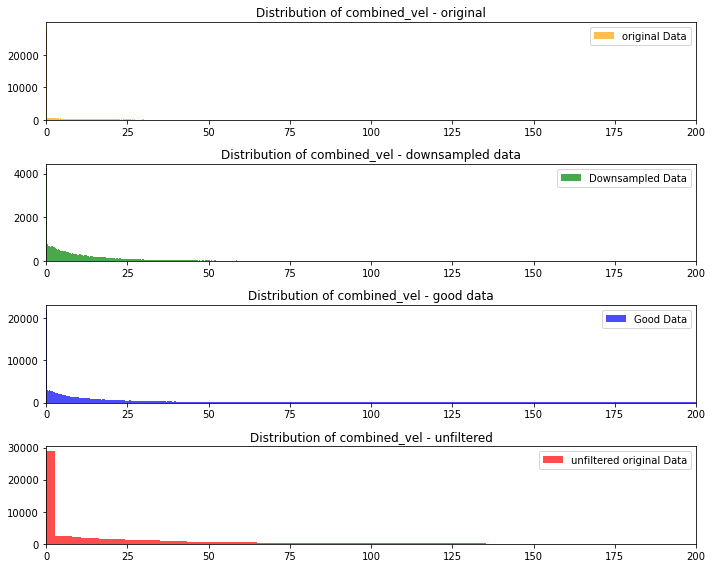

In [104]:
# test plot


import pandas as pd
import matplotlib.pyplot as plt

# # Load your data frames (replace 'file1.csv' and 'file2.csv' with your file paths)
# file= "1004_Session_1_ET_1_data_correTS_mad_wobig.csv"

# data = pd.read_csv(os.path.join(data_savepath_intermediateP, file))

# goodData = pd.read_csv('E:/WestbrookProject/DebbiesData//correTS_mad_wobig_70656182-09b3-4c19-9ae2-0a2ab2e19fed.csv')
# file2 = "1004_Session_1_ET_1_interval_mad_wobig.csv"
# int_data = pd.read_csv(os.path.join(data_savepath_intervals, file2))

# Specify the variable you want to compare
variable_name = 'combined_vel'
binVar = 3000

# Create subplots
fig, axes = plt.subplots(nrows=4, ncols=1, figsize=(10, 8))

# Plot the distribution of the variable in the first subplot
axes[0].hist(data[variable_name], bins = binVar, color='orange', alpha=0.7, label='original Data')
axes[0].set_title(f'Distribution of {variable_name} - original')
axes[0].legend()
axes[0].set_xlim(0, 200)
# axes[0].set_ylim(0, 0.001)
# axes[0].set_xticks(bins)

# Plot the distribution of the variable in the second subplot
axes[1].hist(dataDS[variable_name], bins = binVar, color='green', alpha=0.7, label='Downsampled Data')
axes[1].set_title(f'Distribution of {variable_name} - downsampled data')
axes[1].legend()
axes[1].set_xlim(0, 200)
# axes[1].set_ylim(0, 0.001)
# axes[1].set_xticks(bins)

# Plot the distribution of the variable in the second subplot
axes[2].hist(goodData[variable_name], bins = binVar, color='blue', alpha=0.7, label='Good Data')
axes[2].set_title(f'Distribution of {variable_name} - good data')
axes[2].legend()
axes[2].set_xlim(0, 200)
# axes[2].set_ylim(0, 0.001)
# axes[2].set_xticks(bins[0:10])


# Plot the distribution of the variable in the first subplot
axes[3].hist(dataUnfilt[variable_name], bins = binVar, color='red', alpha=0.7, label='unfiltered original Data')
axes[3].set_title(f'Distribution of {variable_name} - unfiltered')
axes[3].legend()
axes[3].set_xlim(0, 200)


# Adjust layout
plt.tight_layout()

# Show the plots
plt.show()


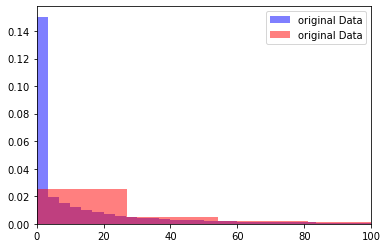

In [99]:
# test plot


import pandas as pd
import matplotlib.pyplot as plt

# # Load your data frames (replace 'file1.csv' and 'file2.csv' with your file paths)
# file= "1004_Session_1_ET_1_data_correTS_mad_wobig.csv"

# data = pd.read_csv(os.path.join(data_savepath_intermediateP, file))

# goodData = pd.read_csv('E:/WestbrookProject/DebbiesData//correTS_mad_wobig_70656182-09b3-4c19-9ae2-0a2ab2e19fed.csv')
# file2 = "1004_Session_1_ET_1_interval_mad_wobig.csv"
# int_data = pd.read_csv(os.path.join(data_savepath_intervals, file2))

# Specify the variable you want to compare
variable_name = 'combined_vel'

# Create subplots
# fig, axes = plt.subplots(nrows=4, ncols=1, figsize=(10, 8))

# Plot the distribution of the variable in the first subplot
plt.hist(data[variable_name], bins = 300, color='blue', alpha=0.5, label='original Data',density = True)

plt.hist(dataUnfilt[variable_name], bins = 300, color='red', alpha=0.5, label='original Data',density = True)



# Plot the distribution of the variable in the second subplot
# plt.hist(dataDS[variable_name], bins = 300, color='red', alpha=0.5, label='Downsampled Data',density = True)
# axes[1].set_title(f'Distribution of {variable_name} - downsampled data')
# axes[1].legend()
# axes[1].set_xlim(0, 200)
# axes[1].set_ylim(0, 0.001)
# axes[1].set_xticks(bins)

# Plot the distribution of the variable in the second subplot
# plt.hist(goodData[variable_name], bins = 300, color='green', alpha=0.5, label='Good Data',density = True)
# axes[2].set_title(f'Distribution of {variable_name} - good data')
# axes[2].legend()
# axes[2].set_xlim(0, 200)
# axes[2].set_ylim(0, 0.001)
# axes[2].set_xticks(bins[0:10])


# Plot the distribution of the variable in the first subplot
# axes[3].set_title(f'Distribution of {variable_name} - original')
# axes[3].legend()
# axes[3].set_xlim(0, 200)


# Adjust layout
# plt.tight_layout()

# Show the plots
plt.legend()
plt.xlim(0, 100)
plt.show()


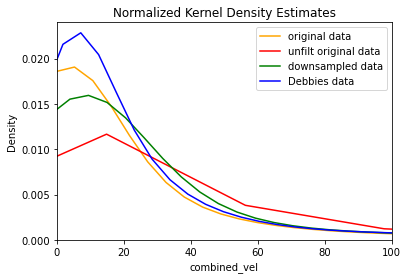

In [106]:
# test plot


import pandas as pd
import matplotlib.pyplot as plt

# # Load your data frames (replace 'file1.csv' and 'file2.csv' with your file paths)
# file= "1004_Session_1_ET_1_data_correTS_mad_wobig.csv"

# data = pd.read_csv(os.path.join(data_savepath_intermediateP, file))

# goodData = pd.read_csv('E:/WestbrookProject/DebbiesData//correTS_mad_wobig_70656182-09b3-4c19-9ae2-0a2ab2e19fed.csv')
# file2 = "1004_Session_1_ET_1_interval_mad_wobig.csv"
# int_data = pd.read_csv(os.path.join(data_savepath_intervals, file2))

# Specify the variable you want to compare
variable_name = 'combined_vel'

# data_norm = data[variable_name]/len(data)
# dataUnfilt_norm = dataUnfilt[variable_name]/len(dataUnfilt)
# dataDS_norm = dataDS[variable_name]/len(dataDS)
# dataGood_norm = goodData[variable_name]/len(goodData)

# # Plot kernel density estimates of normalized data on top of each other
# sns.kdeplot(data_norm, label='original data', color='orange')
# sns.kdeplot(dataUnfilt_norm, label='unfilt original data', color='red')
# sns.kdeplot(dataDS_norm, label='downsampled data', color='green')
# sns.kdeplot(dataGood_norm, label='Debbies data', color='blue')


# data_norm = data[variable_name]/len(data)
# dataUnfilt_norm = dataUnfilt[variable_name]/len(dataUnfilt)
# dataDS_norm = dataDS[variable_name]/len(dataDS)
# dataGood_norm = goodData[variable_name]/len(goodData)

# Plot kernel density estimates of normalized data on top of each other
sns.kdeplot(data[variable_name], label='original data', color='orange')
sns.kdeplot(dataUnfilt[variable_name], label='unfilt original data', color='red')
sns.kdeplot(dataDS[variable_name], label='downsampled data', color='green')
sns.kdeplot(goodData[variable_name], label='Debbies data', color='blue')



plt.xlabel(variable_name)
plt.ylabel('Density')
plt.title('Normalized Kernel Density Estimates')
plt.legend()

plt.xlim(0, 100)

plt.show()

# Create subplots
# fig, axes = plt.subplots(nrows=4, ncols=1, figsize=(10, 8))

# Plot the distribution of the variable in the first subplot
# sns.kdeplot(data=data[variable_name])
# axes[0].set_title(f'Distribution of {variable_name} - original')
# axes[0].legend()
# axes[0].set_xlim(0, 200)
# # axes[0].set_ylim(0, 0.001)
# # axes[0].set_xticks(bins)

# # Plot the distribution of the variable in the second subplot
# axes[1].hist(dataDS[variable_name], bins = 300, color='blue', alpha=0.7, label='Downsampled Data')
# axes[1].set_title(f'Distribution of {variable_name} - downsampled data')
# axes[1].legend()
# axes[1].set_xlim(0, 200)
# # axes[1].set_ylim(0, 0.001)
# # axes[1].set_xticks(bins)

# # Plot the distribution of the variable in the second subplot
# axes[2].hist(goodData[variable_name], bins = 300, color='blue', alpha=0.7, label='Good Data')
# axes[2].set_title(f'Distribution of {variable_name} - good data')
# axes[2].legend()
# axes[2].set_xlim(0, 200)
# # axes[2].set_ylim(0, 0.001)
# # axes[2].set_xticks(bins[0:10])


# # Plot the distribution of the variable in the first subplot
# axes[3].hist(dataUnfilt[variable_name], bins = 300, color='orange', alpha=0.7, label='original Data')
# axes[3].set_title(f'Distribution of {variable_name} - original')
# axes[3].legend()
# axes[3].set_xlim(0, 200)


# # Adjust layout
# plt.tight_layout()

# # Show the plots
# plt.show()


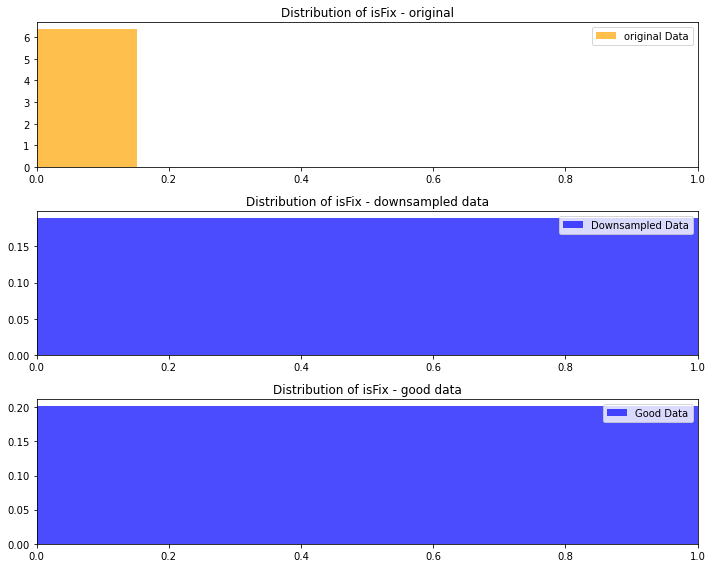

In [174]:
# test plot


import pandas as pd
import matplotlib.pyplot as plt

# # Load your data frames (replace 'file1.csv' and 'file2.csv' with your file paths)
# file= "1004_Session_1_ET_1_data_correTS_mad_wobig.csv"

# data = pd.read_csv(os.path.join(data_savepath_intermediateP, file))

# goodData = pd.read_csv('E:/WestbrookProject/DebbiesData//correTS_mad_wobig_70656182-09b3-4c19-9ae2-0a2ab2e19fed.csv')
# file2 = "1004_Session_1_ET_1_interval_mad_wobig.csv"
# int_data = pd.read_csv(os.path.join(data_savepath_intervals, file2))

# Specify the variable you want to compare
variable_name = 'isFix'

# Create subplots
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(10, 8))

# Plot the distribution of the variable in the first subplot
axes[0].hist(data.loc[data['isFix'].notna(), 'combined_vel'], bins = 1000, color='orange', alpha=0.7, label='original Data', density=True)
axes[0].set_title(f'Distribution of {variable_name} - original')
axes[0].legend()
axes[0].set_xlim(0, 1)
# axes[0].set_ylim(0, 0.001)
# axes[0].set_xticks(bins)

# Plot the distribution of the variable in the second subplot
axes[1].hist(dataDS.loc[dataDS['isFix'].notna(), 'combined_vel'], bins = 1000, color='blue', alpha=0.7, label='Downsampled Data', density=True)
axes[1].set_title(f'Distribution of {variable_name} - downsampled data')
axes[1].legend()
axes[1].set_xlim(0, 1)
# axes[1].set_ylim(0, 0.001)
# axes[1].set_xticks(bins)

# Plot the distribution of the variable in the second subplot
axes[2].hist(goodData.loc[goodData['isFix'].notna(), 'combined_vel'], bins = 1000, color='blue', alpha=0.7, label='Good Data', density=True)
axes[2].set_title(f'Distribution of {variable_name} - good data')
axes[2].legend()
axes[2].set_xlim(0, 1)
# axes[2].set_ylim(0, 0.001)
# axes[2].set_xticks(bins[0:10])


# Adjust layout
plt.tight_layout()

# Show the plots
plt.show()


In [114]:
print(hist.bins)

NameError: name 'hist' is not defined

In [118]:
print('--------- median all velocities----------')
print(np.nanmedian(data['combined_vel']))
print(np.nanmedian(dataUnfilt['combined_vel']))
print(np.nanmedian(dataDS['combined_vel']))
print(np.nanmedian(goodData['combined_vel']))

print('--------- mean all velocities----------')
print(np.mean(data['combined_vel']))
print(np.mean(dataUnfilt['combined_vel']))
print(np.mean(dataDS['combined_vel']))
print(np.mean(goodData['combined_vel']))


print('--------- 0s in velocities----------')
print((data['combined_vel']== 0).sum()/len(data))
print((dataUnfilt['combined_vel']== 0).sum()/len(dataUnfilt))
print((dataDS['combined_vel']== 0).sum()/len(dataDS))
print((goodData['combined_vel']== 0).sum()/len(goodData))


print('--------- NaNs in velocities----------')
print(data['combined_vel'].isna().sum()/len(data))
print(dataUnfilt['combined_vel'].isna().sum()/len(dataUnfilt))
print(dataDS['combined_vel'].isna().sum()/len(dataDS))
print(goodData['combined_vel'].isna().sum()/len(goodData))

--------- median all velocities----------
3.264221780707162
7.593282037717474
10.575228051673637
10.67012299410869
--------- mean all velocities----------
45.51703684730561
59.03958261899376
56.499197154644406
45.063388349829836
--------- 0s in velocities----------
0.022653430954199045
0.4123583224782524
0.0005488474204171241
0.0019456094081023822
--------- NaNs in velocities----------
0.005045741065145458
0.005345191573462696
0.004861220009408813
0.013662501621341173


In [119]:
def count_consecutive_zeros(dataVar):
    
    # Initialize variables
    consecutive_zeros = 0
    consecutive_zero_clusters = []

    # Iterate over 'A' column to count consecutive zero clusters
    for value in dataVar:
        if value == 0:
            consecutive_zeros += 1
        elif consecutive_zeros > 0:
            consecutive_zero_clusters.append(consecutive_zeros)
            consecutive_zeros = 0

    # Add last cluster if it ends with zero
    if consecutive_zeros > 0:
        consecutive_zero_clusters.append(consecutive_zeros)

    return consecutive_zero_clusters

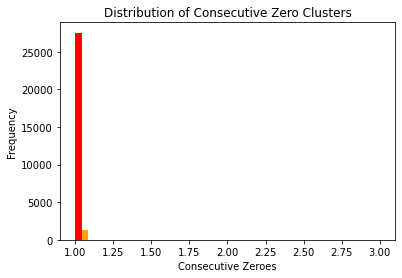

(array([2.7535e+04, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 3.0000e+00]),
 array([1.        , 1.04166667, 1.08333333, 1.125     , 1.16666667,
        1.20833333, 1.25      , 1.29166667, 1.33333333, 1.375     ,
        1.41666667, 1.45833333, 1.5       , 1.54166667, 1.58333333,
        1.625     , 1.66666667, 1.70833333, 1.75      , 1.79166667,
        1.83333333, 1.875     , 1.91666667, 1.95833333, 2.        ]),
 <BarContainer object of 24 artists>)

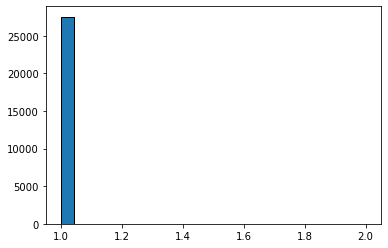

In [136]:
# count consecutive zero clusters

# Example DataFrame
df1 = pd.DataFrame({'A': [0, 1, 0, 0, 0, 2, 0, 0, 3, 0, 0, 0, 4, 0, 5, 0]})

zeroClusters_data = count_consecutive_zeros(data['combined_vel'])

zeroClusters_unfilt = count_consecutive_zeros(dataUnfilt['combined_vel'])


zeroClusters_DS = count_consecutive_zeros(dataDS['combined_vel'])

zeroClusters_goodData = count_consecutive_zeros(goodData['combined_vel'])

maxBins = max([max(zeroClusters_data),max(zeroClusters_unfilt), max(zeroClusters_DS), max(zeroClusters_goodData)])


# Create histogram
plt.hist(zeroClusters_data, bins=maxBins+1, color='orange')

plt.hist(zeroClusters_unfilt,maxBins+1, color='red')

# plt.hist(zeroClusters_DS,maxBins+1, color='green')

# plt.hist(zeroClusters_goodData,maxBins+1, color='blue')


plt.xlabel('Consecutive Zeroes')
plt.ylabel('Frequency')
plt.title('Distribution of Consecutive Zero Clusters')
plt.show()

plt.hist(zeroClusters_unfilt,maxBins+1, edgecolor='black')


---------- time differences /sampling rate in hz when combined vel is 0---------
403.2596865685992
65.01990450796801
323.7353397303073
335.57116569325547
---------- all time differences---------
403.2596865685992
7.07414666068483
111.26672367481477
125.94372879320181


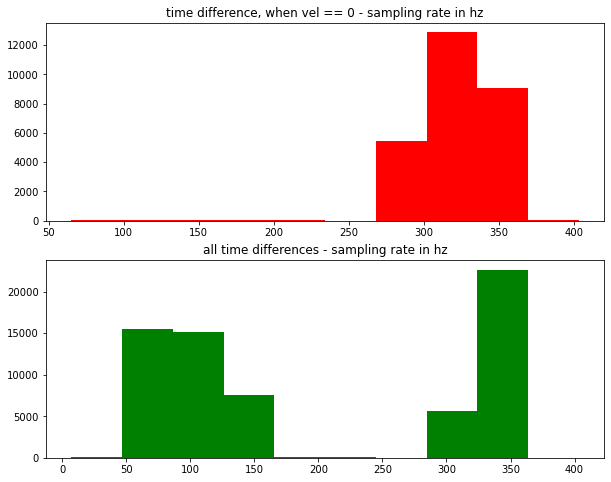

In [226]:
dataUnfilt['time_diff'] = dataUnfilt['timeStampDataPointStart_converted'].diff()


dataVel0 = dataUnfilt.loc[dataUnfilt['combined_vel'] == 0, 'time_diff']

print('---------- time differences /sampling rate in hz when combined vel is 0---------')

print(1/np.nanmin(dataVel0))
print(1/np.nanmax(dataVel0))
print(1/np.nanmean(dataVel0))
print(1/np.nanmedian(dataVel0))

print('---------- all time differences---------')
print(1/np.nanmin(dataUnfilt['time_diff']))
print(1/np.nanmax(dataUnfilt['time_diff']))
print(1/np.nanmean(dataUnfilt['time_diff']))
print(1/np.nanmedian(dataUnfilt['time_diff']))

fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(10, 8))

axes[0].hist(1/dataVel0, color='red')
axes[0].set_title('time difference, when vel == 0 - sampling rate in hz')


axes[1].hist(1/dataUnfilt['time_diff'], color= 'green')
axes[1].set_title('all time differences - sampling rate in hz')


# plt.xlabel('combined velocity')
# plt.ylabel('Frequency')
# plt.title('Distribution of time differences')
plt.show()# dataUnfilt.head()

Number of removed data rows: 28527
Percentage of removed data: 0.42712123253829226
----------------------
length raw file  66789
length file after downsampling  38262
----------------------
slowest sampling rate raw  7.07414666068483
slowest sampling rate after removal  6.928576738257297
----------------------
fastest sampling rate raw  403.2596865685992
fastest sampling rate after removal  155.28132982858835
----------------------
mean sampling rate raw  111.26672367481477
mean sampling rate after removal  63.74237000250753
----------------------
median sampling rate raw  125.94372879320181
median sampling rate after removal  87.64243475309995
----------------------
120 sampling rate =  0.008333333333333333
90 sampling rate =  0.011111111111111112
Index(['eyePositionCombinedWorld_x', 'eyePositionCombinedWorld_y',
       'eyePositionCombinedWorld_z'],
      dtype='object')


D:\Software\Programme\Anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


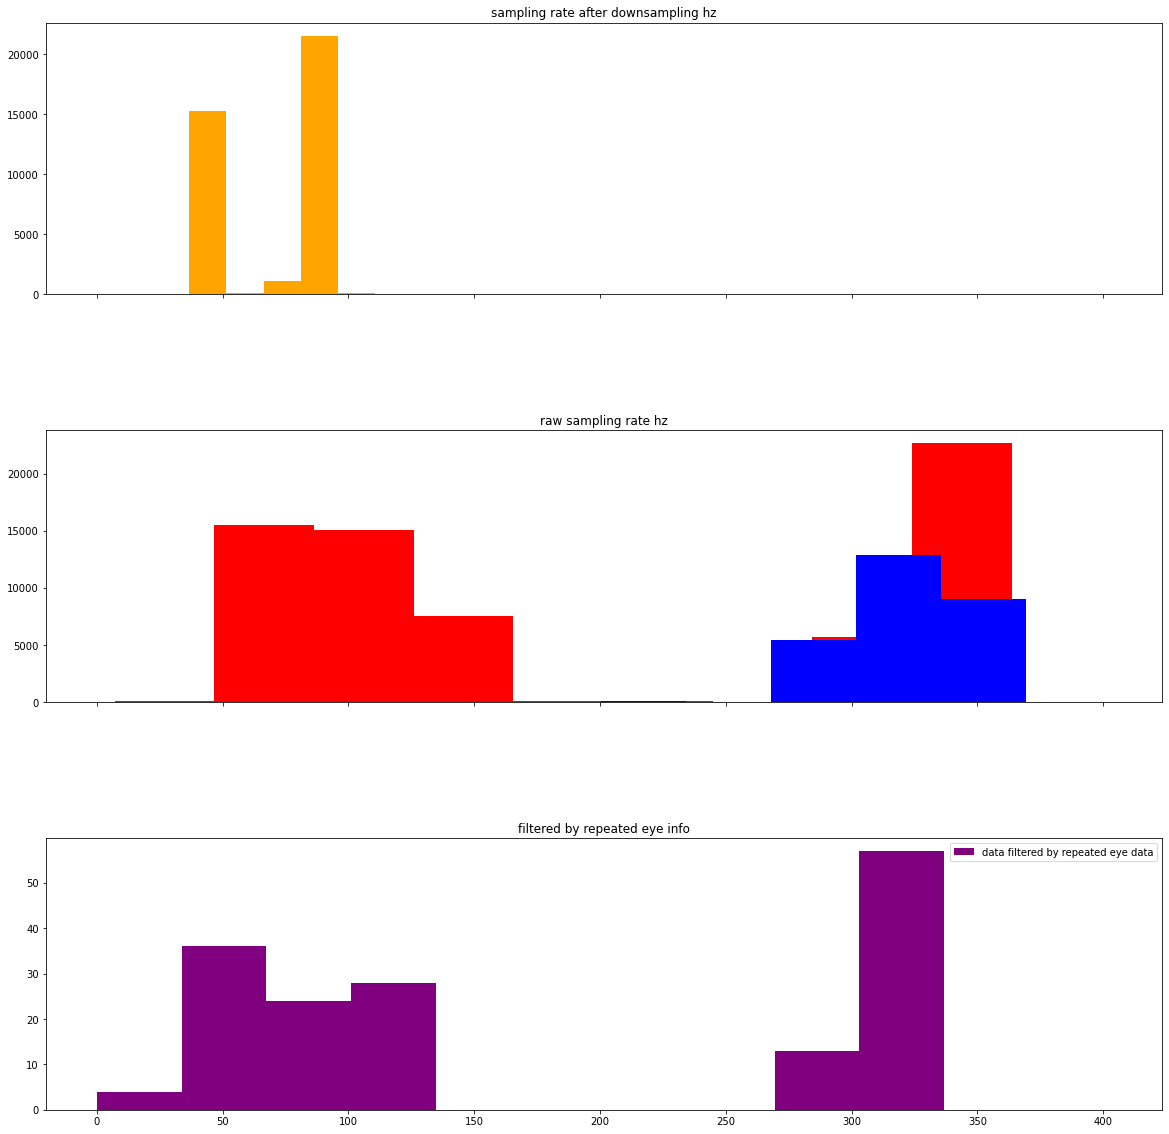

In [264]:
testData = dataUnfilt

testData = droppRows(file, testData)
testData['time_diff_afterRM'] = testData['timeStampDataPointStart_converted'].diff()

dataUnfilt['time_diff'] = dataUnfilt['timeStampDataPointStart_converted'].diff()

print('----------------------')
print('length raw file ', len(dataUnfilt))
print('length file after downsampling ', len(testData))

print('----------------------')

print('slowest sampling rate raw ', 1/ np.nanmax(dataUnfilt['time_diff']))

print('slowest sampling rate after removal ', 1/np.nanmax(testData['time_diff_afterRM']))

print('----------------------')

print('fastest sampling rate raw ', 1/np.nanmin(dataUnfilt['time_diff']))

print('fastest sampling rate after removal ', 1/np.nanmin(testData['time_diff_afterRM']))

print('----------------------')

print('mean sampling rate raw ', 1/np.nanmean(dataUnfilt['time_diff']))

print('mean sampling rate after removal ', 1/np.nanmean(testData['time_diff_afterRM']))

print('----------------------')

print('median sampling rate raw ', 1/np.nanmedian(dataUnfilt['time_diff']))

print('median sampling rate after removal ', 1/np.nanmedian(testData['time_diff_afterRM']))


print('----------------------')

print('120 sampling rate = ', 1/120)
print('90 sampling rate = ', 1/90)

fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(20, 20), sharex=True, gridspec_kw={'hspace': 0.5})

axes[0].hist(1/testData['time_diff_afterRM'], color='orange')
axes[0].set_title('sampling rate after downsampling hz')

zerosData = dataUnfilt[dataUnfilt['combined_vel']==0]
axes[1].hist(1/dataUnfilt['time_diff'], color= 'red')
axes[1].hist(1/zerosData['time_diff'], color='blue')

axes[1].set_title('raw sampling rate hz')


notZerosData = dataUnfilt[dataUnfilt['combined_vel']!=0]
notZerosData['newTimeDiff'] = notZerosData['timeStampDataPointStart_converted'].diff()


columns_to_check = dataUnfilt.columns[10:13]
print(columns_to_check)

testi = dataUnfilt.copy()
# Check if differences between consecutive rows are consistently 0 for the selected columns
testi['repeated_rows'] =  dataUnfilt[columns_to_check].diff(axis=1).fillna(0).eq(0).all(axis=1)

testi = testi[testi['repeated_rows']!= 0]
testi['newTimeDiff'] = testi['timeStampDataPointStart_converted'].diff()


# axes[2].hist(1/dataUnfilt['time_diff'], color= 'orange', label='original data')
# axes[2].hist(1/notZerosData['newTimeDiff'], color='red', label= 'data filtered where vel is not 0')
axes[2].hist(1/testi['newTimeDiff'], color='purple', label= 'data filtered by repeated eye data')


axes[2].set_title('filtered by repeated eye info')
axes[2].legend()

# testData.head()


In [261]:
# Select columns 30-70
columns_to_check = dataUnfilt.columns[10:13]
print(columns_to_check)

testi = dataUnfilt.copy()
# Check if differences between consecutive rows are consistently 0 for the selected columns
testi['repeated_rows'] =  dataUnfilt[columns_to_check].diff(axis=1).fillna(0).eq(0).all(axis=1)

testi = testi[testi['repeated_rows']!= 0]
testi['newTimeDiff'] = testi['timeStampDataPointStart_converted'].diff()
testi.head()

Index(['eyePositionCombinedWorld_x', 'eyePositionCombinedWorld_y',
       'eyePositionCombinedWorld_z'],
      dtype='object')


,timeStampDataPointStart,timeStampDataPointEnd,timeStampGetVerboseData,eyeOpennessLeft,eyeOpennessRight,pupilDiameterMillimetersLeft,pupilDiameterMillimetersRight,leftGazeValidityBitmask,rightGazeValidityBitmask,combinedGazeValidityBitmask,eyePositionCombinedWorld_x,eyePositionCombinedWorld_y,eyePositionCombinedWorld_z,eyeDirectionCombinedWorld_x,eyeDirectionCombinedWorld_y,eyeDirectionCombinedWorld_z,eyeDirectionCombinedLocal_x,eyeDirectionCombinedLocal_y,eyeDirectionCombinedLocal_z,eyePositionLeftWorld_x,eyePositionLeftWorld_y,eyePositionLeftWorld_z,eyeDirectionLeftWorld_x,eyeDirectionLeftWorld_y,eyeDirectionLeftWorld_z,eyeDirectionLeftLocal_x,eyeDirectionLeftLocal_y,eyeDirectionLeftLocal_z,eyePositionRightWorld_x,eyePositionRightWorld_y,eyePositionRightWorld_z,eyeDirectionRightWorld_x,eyeDirectionRightWorld_y,eyeDirectionRightWorld_z,eyeDirectionRightLocal_x,eyeDirectionRightLocal_y,eyeDirectionRightLocal_z,hmdPosition_x,hmdPosition_y,hmdPosition_z,hmdDirectionForward_x,hmdDirectionForward_y,hmdDirectionForward_z,hmdDirectionRight_x,hmdDirectionRight_y,hmdDirectionRight_z,hmdRotation_x,hmdRotation_y,hmdRotation_z,hmdDirectionUp_x,hmdDirectionUp_y,hmdDirectionUp_z,handLeftPosition_x,handLeftPosition_y,handLeftPosition_z,handRightPosition_x,handRightPosition_y,handRightPosition_z,handRightRotation_x,handRightRotation_y,handRightRotation_z,handRightDirectionForward_x,handRightDirectionForward_y,handRightDirectionForward_z,handRightDirectionRight_x,handRightDirectionRight_y,handRightDirectionRight_z,handRightDirectionUp_x,handRightDirectionUp_y,handRightDirectionUp_z,playerBodyPosition_x,playerBodyPosition_y,playerBodyPosition_z,bodyTrackerPosition_x,bodyTrackerPosition_y,bodyTrackerPosition_z,bodyTrackerRotation_x,bodyTrackerRotation_y,bodyTrackerRotation_z,hitObjectColliderName_1,ordinalOfHit_1,hitPointOnObject_x_1,hitPointOnObject_y_1,hitPointOnObject_z_1,hitObjectColliderBoundsCenter_x_1,hitObjectColliderBoundsCenter_y_1,hitObjectColliderBoundsCenter_z_1,hitObjectColliderName_2,ordinalOfHit_2,hitPointOnObject_x_2,hitPointOnObject_y_2,hitPointOnObject_z_2,hitObjectColliderBoundsCenter_x_2,hitObjectColliderBoundsCenter_y_2,hitObjectColliderBoundsCenter_z_2,DataRow,hitObjectColliderisGraffiti_1,hitObjectColliderisGraffiti_2,processedCollider_name,processedCollider_hitPointOnObject_x,processedCollider_hitPointOnObject_y,processedCollider_hitPointOnObject_z,processedCollider_hitObjectColliderBoundsCenter_x,processedCollider_hitObjectColliderBoundsCenter_y,processedCollider_hitObjectColliderBoundsCenter_z,replacedRows,processedColliderIsNH,processedCollider_NH_name,processedCollider_NH_hitPointOnObject_x,processedCollider_NH_hitPointOnObject_y,processedCollider_NH_hitPointOnObject_z,processedCollider_NH_hitObjectColliderBoundsCenter_x,processedCollider_NH_hitObjectColliderBoundsCenter_y,processedCollider_NH_hitObjectColliderBoundsCenter_z,replacedRows_NH,processedCollider_NH_IsNH,timeStampDataPointStart_converted,cleanData,isBlink,processedCollider_name_interpolated,processedCollider_NH_name_interpolated,combined_vel,time_diff,repeated_rows,newTimeDiff
25799,1.618996e+09,1.618996e+09,1.618996e+09,0.634622,0.451694,4.395309,-1.0,31,25,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,106.919281,0.552608,7.907059,-0.669786,0.382480,-0.636472,-0.685145,0.012145,0.728305,337.512634,226.460922,0.753137,0.286292,0.923884,0.253920,106.958786,-1.014113,8.139252,106.922302,-0.023101,7.655136,334.178467,171.095108,341.227081,0.139339,0.435569,-0.889305,-0.913691,-0.289686,-0.285045,-0.381776,0.852268,0.357611,106.958786,-1.014113,8.139252,106.917725,0.066970,7.914993,349.641846,194.241913,356.587708,noHit,NaN,NaN,NaN,NaN,NaN,NaN,NaN,noHit,NaN,NaN,NaN,NaN,NaN,NaN,NaN,25799,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,notReplaced,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,notReplaced,1,236.01331,True,True,NaN,NaN,NaN,0.01935,True,NaN
25800,1.618996e+09,1.618996e+09,1.618996e+09,0.634622,0.451694,4.395309,-1.

In [246]:
for idx, column_name in enumerate(data.columns):
    print(f"Index: {idx}, Column Name: {column_name}")

Index: 0, Column Name: timeStampDataPointStart
Index: 1, Column Name: timeStampDataPointEnd
Index: 2, Column Name: timeStampGetVerboseData
Index: 3, Column Name: eyeOpennessLeft
Index: 4, Column Name: eyeOpennessRight
Index: 5, Column Name: pupilDiameterMillimetersLeft
Index: 6, Column Name: pupilDiameterMillimetersRight
Index: 7, Column Name: leftGazeValidityBitmask
Index: 8, Column Name: rightGazeValidityBitmask
Index: 9, Column Name: combinedGazeValidityBitmask
Index: 10, Column Name: eyePositionCombinedWorld_x
Index: 11, Column Name: eyePositionCombinedWorld_y
Index: 12, Column Name: eyePositionCombinedWorld_z
Index: 13, Column Name: eyeDirectionCombinedWorld_x
Index: 14, Column Name: eyeDirectionCombinedWorld_y
Index: 15, Column Name: eyeDirectionCombinedWorld_z
Index: 16, Column Name: eyeDirectionCombinedLocal_x
Index: 17, Column Name: eyeDirectionCombinedLocal_y
Index: 18, Column Name: eyeDirectionCombinedLocal_z
Index: 19, Column Name: eyePositionLeftWorld_x
Index: 20, Column N

D:\Software\Programme\Anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Text(0.5, 1.0, 'Sampling rate - Debbies data')

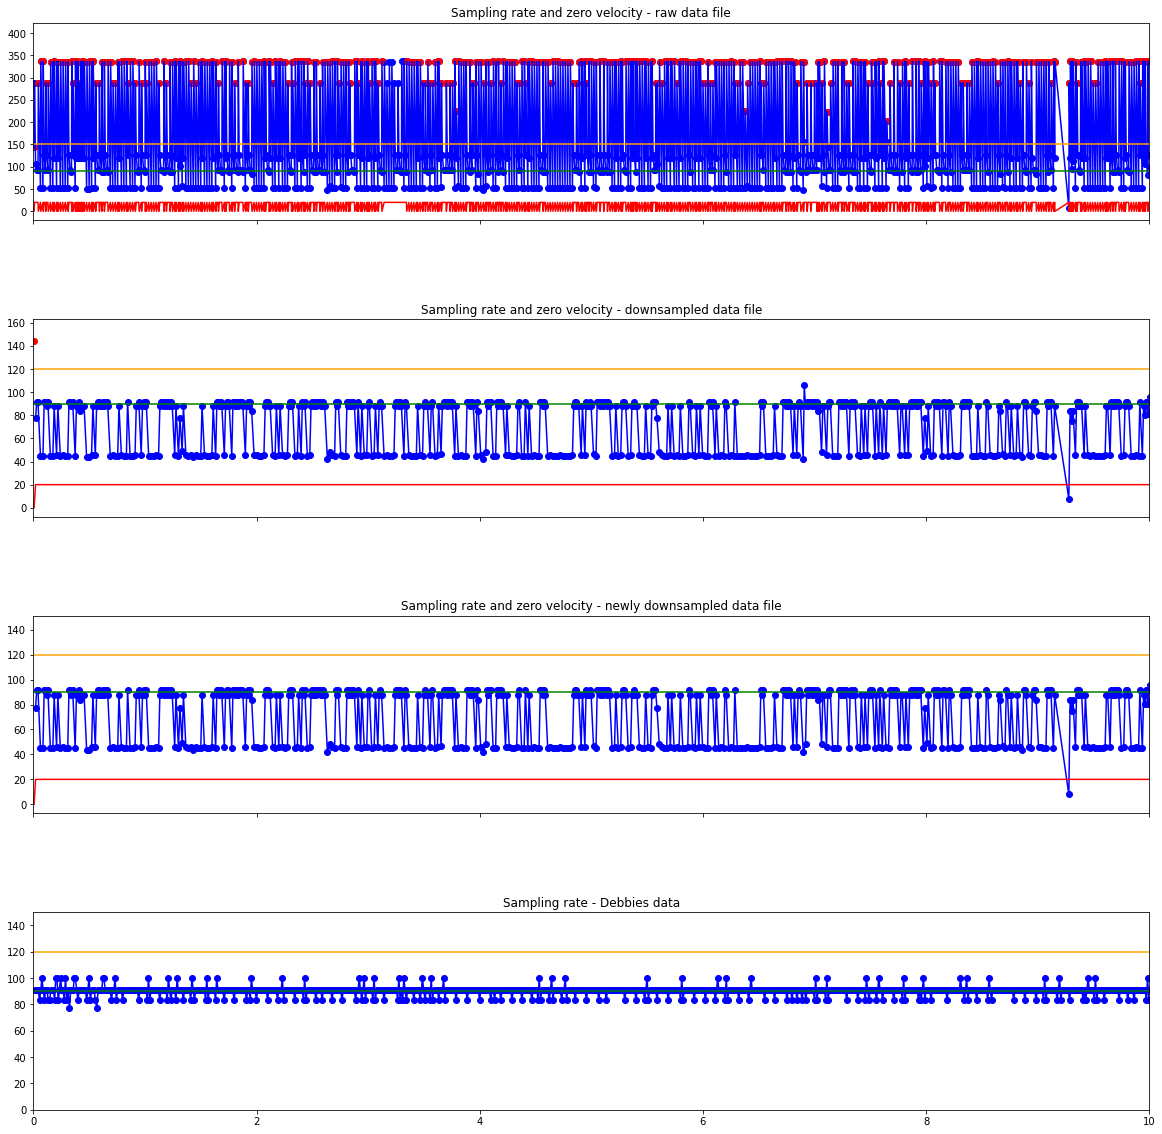

In [268]:
fig, axes = plt.subplots(nrows=4, ncols=1, figsize=(20, 20), sharex=True, gridspec_kw={'hspace': 0.5})

showVel_unfilt = np.copy(dataUnfilt['combined_vel'])

showVel_unfilt[showVel_unfilt != 0] = 20
limMin = 0
limMax = 10

zerosData = dataUnfilt[dataUnfilt['combined_vel'] == 0]
# zerosData.head()

axes[0].plot(dataUnfilt['timeStampDataPointStart_converted'],1/dataUnfilt['time_diff'], color = 'blue')
axes[0].scatter(dataUnfilt['timeStampDataPointStart_converted'],1/dataUnfilt['time_diff'], color = 'blue')
axes[0].plot(dataUnfilt['timeStampDataPointStart_converted'],showVel_unfilt, color = 'red')
axes[0].scatter(zerosData['timeStampDataPointStart_converted'],1/zerosData['time_diff'], color = 'red')

axes[0].axhline(y=90, color='green')

axes[0].axhline(y=150, color='orange')

axes[0].set_xlim(limMin, limMax)
axes[0].set_title('Sampling rate and zero velocity - raw data file')

# for timestamps in testData['timeStampDataPointStart_converted']:
#     axes[0].axvline(x=1 / timestamps , color='red', linestyle='--', linewidth=0.5)

showVel_testi = np.copy(testData['combined_vel'])

showVel_testi[showVel_testi != 0] = 20

zerosData2 = testData[testData['combined_vel'] == 0]

axes[1].plot(testData['timeStampDataPointStart_converted'],1/testData['time_diff_afterRM'], color = 'blue')
axes[1].scatter(testData['timeStampDataPointStart_converted'],1/testData['time_diff_afterRM'], color = 'blue')
axes[1].plot(testData['timeStampDataPointStart_converted'],showVel_testi, color = 'red')
axes[1].scatter(zerosData2['timeStampDataPointStart_converted'],1/zerosData2['time_diff'], color = 'red')

axes[1].axhline(y=90, color='green')

axes[1].axhline(y=120, color='orange')

axes[1].set_xlim(limMin, limMax)

axes[1].set_title('Sampling rate and zero velocity - downsampled data file')
###########################

data_newThreshDS = dataUnfilt[dataUnfilt['time_diff']> 0.0067]

data_newThreshDS['newTimeDiff'] = data_newThreshDS['timeStampDataPointStart_converted'].diff() 

showVel_newThresh= np.copy(data_newThreshDS['combined_vel'])

showVel_newThresh[showVel_newThresh != 0] = 20

zerosData3 = data_newThreshDS[data_newThreshDS['combined_vel'] == 0]


axes[2].plot(data_newThreshDS['timeStampDataPointStart_converted'],1/data_newThreshDS['newTimeDiff'], color = 'blue')
axes[2].scatter(data_newThreshDS['timeStampDataPointStart_converted'],1/data_newThreshDS['newTimeDiff'], color = 'blue')
axes[2].plot(data_newThreshDS['timeStampDataPointStart_converted'],showVel_newThresh, color = 'red')
axes[2].scatter(zerosData3['timeStampDataPointStart_converted'],1/zerosData3['newTimeDiff'], color = 'red')

axes[2].axhline(y=90, color='green')

axes[2].axhline(y=120, color='orange')

axes[2].set_xlim(limMin, limMax)
axes[2].set_title('Sampling rate and zero velocity - newly downsampled data file')
###############################################

goodData['timeDiff'] = goodData['time'].diff()

axes[3].plot(goodData['time'],1/goodData['timeDiff'], color = 'blue')
axes[3].scatter(goodData['time'],1/goodData['timeDiff'], color = 'blue')

axes[3].axhline(y=90, color='green')

axes[3].axhline(y=120, color='orange')

axes[3].set_xlim(limMin, limMax)
axes[3].set_ylim(0,150)

axes[3].set_title('Sampling rate - Debbies data')

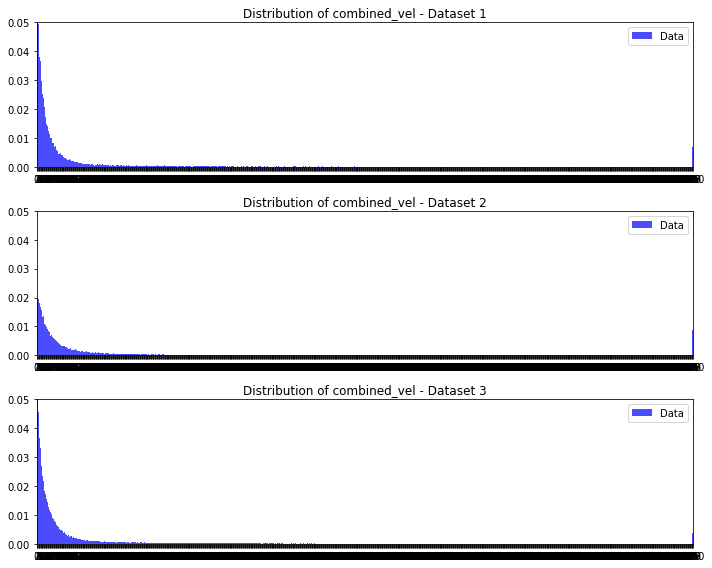

In [102]:
# test plot


import pandas as pd
import matplotlib.pyplot as plt

# # Load your data frames (replace 'file1.csv' and 'file2.csv' with your file paths)
# file= "1004_Session_1_ET_1_data_correTS_mad_wobig.csv"

# data = pd.read_csv(os.path.join(data_savepath_intermediateP, file))

# goodData = pd.read_csv('E:/WestbrookProject/DebbiesData//correTS_mad_wobig_70656182-09b3-4c19-9ae2-0a2ab2e19fed.csv')
# file2 = "1004_Session_1_ET_1_interval_mad_wobig.csv"
# int_data = pd.read_csv(os.path.join(data_savepath_intervals, file2))

# Specify the variable you want to compare
variable_name = 'combined_vel'

# Create subplots
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(10, 8))


# Plot the distribution of the variable in each subplot
for i, dataset in enumerate([data[variable_name], data2[variable_name], goodData[variable_name]]):
    # Plot histogram and capture bin edges
    n, bins, _ = axes[i].hist(dataset, bins=1000, color='blue', alpha=0.7, label='Data', density=True)
    axes[i].set_title(f'Distribution of {variable_name} - Dataset {i+1}')
    axes[i].legend()
    axes[i].set_ylim(0, 0.05)
    axes[i].set_xlim(0,bins[10])

    # Set bin edges as x-labels
    axes[i].set_xticks(bins)



# Adjust layout
plt.tight_layout()

# Show the plots
plt.show()


In [17]:
import pandas as pd
import matplotlib.pyplot as plt

# Load your data frames (replace 'file1.csv' and 'file2.csv' with your file paths)
goodData = pd.read_csv('E:/WestbrookProject/DebbiesData//correTS_mad_wobig_70656182-09b3-4c19-9ae2-0a2ab2e19fed.csv')
file2 = "1004_Session_5_ET_1_interval_mad_wobig.csv"
int_data = pd.read_csv(os.path.join(data_savepath_intervals, file2))

# Specify the variable you want to compare
variable_name = 'combined_vel'

# Create subplots
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(10, 8))

# Plot the distribution of the variable in the first subplot
hist1, bins1, _ = axes[0].hist(data[variable_name], bins=6000, color='blue', alpha=0.7, label='My Data')
axes[0].set_title(f'Distribution of {variable_name} - my data')
axes[0].legend()
axes[0].set_xlim(0, 1)

# Plot the distribution of the variable in the second subplot
hist2, bins2, _ = axes[1].hist(goodData[variable_name], bins=6000, color='orange', alpha=0.7, label='Good Data')
axes[1].set_title(f'Distribution of {variable_name} - good data')
axes[1].legend()
axes[1].set_xlim(0, 1)

# # Scale the y-axis to represent percentages (0-100%)
# max_density = max(max(hist1), max(hist2))  # Maximum density among the two histograms
# for ax in axes:
#     ax.set_ylim(0, max_density * 100)  # Set y-axis limits to 0-100%

# Adjust layout
plt.tight_layout()

# Show the plots
plt.show()


KeyboardInterrupt: 

In [20]:
file= "1004_Session_5_ET_3_data_correTS_mad_wobig.csv"
data_path_old = "E:/WestbrookProject/SpaRe_Data/control_data/pre-processing_2023/velocity_based/step3_gazeProcessing/oldProcessing/intermediateProcessing"

dataDS = pd.read_csv(os.path.join(data_savepath_intermediateP, file))
data = pd.read_csv(os.path.join(data_path_old, file))

print('------------mean velocity-------------')
print(np.mean(goodData['combined_vel']))
print(np.mean(dataDS['combined_vel']))
print(np.mean(data['combined_vel']))

print('-------------median velocity--------------')
print(np.nanmedian(goodData['combined_vel']))
print(np.nanmedian(dataDS['combined_vel']))
print(np.nanmedian(data['combined_vel']))

print(np.max(goodData['combined_vel']))
print(np.max(dataDS['combined_vel']))
print(np.max(data['combined_vel']))

print(np.mean(goodData['isFix']))
print(np.mean(dataDS['isFix']))
print(np.mean(data['isFix']))
print('----------------')

print(goodData['events'].value_counts().get(2, 0))
print(dataDS['events'].value_counts().get(2, 0))
print(data['events'].value_counts().get(2, 0))

print(goodData['events'].value_counts().get(-2, 0))
print(dataDS['events'].value_counts().get(-2, 0))
print(data['events'].value_counts().get(-2, 0))

print(goodData['events'].value_counts().get(1, 0))
print(dataDS['events'].value_counts().get(1, 0))
print(data['events'].value_counts().get(1, 0))

print(goodData['events'].value_counts().get(-1, 0))
print(dataDS['events'].value_counts().get(-1, 0))
print(data['events'].value_counts().get(-1, 0))


print('-------fixation count----------------')
sGood = goodData['isFix'].notna().sum()/len(goodData)
sDS = dataDS['isFix'].notna().sum()/len(dataDS)
sN = data['isFix'].notna().sum()/len(data)

print(sGood)
print(sDS)
print(sN)
    
print('-------mean fixation vel----------------')

mean1_combined_vel = goodData.loc[goodData['isFix'].notna(), 'combined_vel'].mean()
mean3_combined_vel = dataDS.loc[data['isFix'].notna(), 'combined_vel'].mean()
mean2_combined_vel = data.loc[data['isFix'].notna(), 'combined_vel'].mean()

print(mean1_combined_vel)
print(mean3_combined_vel)
print(mean2_combined_vel)

print('-------median fixation vel----------------')

mean1_combined_vel = goodData.loc[goodData['isFix'].notna(), 'combined_vel'].median()
mean3_combined_vel = dataDS.loc[data['isFix'].notna(), 'combined_vel'].median()
mean2_combined_vel = data.loc[data['isFix'].notna(), 'combined_vel'].median()

print(mean1_combined_vel)
print(mean3_combined_vel)
print(mean2_combined_vel)

print('---------mean saccade vel -------------------')

mean1_combined_vel = goodData.loc[goodData['isFix'].isna(), 'combined_vel'].mean()
mean3_combined_vel = dataDS.loc[dataDS['isFix'].isna(), 'combined_vel'].mean()
mean2_combined_vel = data.loc[data['isFix'].isna(), 'combined_vel'].mean()

print(mean1_combined_vel)
print(mean3_combined_vel)
print(mean2_combined_vel)

print('---------median saccade vel -------------------')

med1_combined_vel = goodData.loc[goodData['isFix'].isna(), 'combined_vel'].median()
med3_combined_vel = dataDS.loc[dataDS['isFix'].isna(), 'combined_vel'].median()
med2_combined_vel = data.loc[data['isFix'].isna(), 'combined_vel'].median()

print(med1_combined_vel)
print(med3_combined_vel)
print(med2_combined_vel)

print('-------------------')
print('percentage fixations-----------')
print(goodData['isFix'].notna().sum()/len(goodData))
print(dataDS['isFix'].notna().sum()/len(dataDS))
print(data['isFix'].notna().sum()/len(data))

print('-------------------')

print('percentage saccades----------------')
print(goodData['isFix'].isna().sum()/len(goodData))
print(dataDS['isFix'].isna().sum()/len(dataDS))
print(data['isFix'].isna().sum()/len(data))

------------mean velocity-------------
45.063388349829836
53.350448244731965
44.441109077297845
-------------median velocity--------------
10.67012299410869
10.455142344132105
3.2049526566716366
1000.0000000000003
1000.0
1000.0
13.65367238239994
13.736125085831834
9.463824938945908
----------------
5117
2243
422
5117
2243
424
5117
2242
424
5103
1770
424
-------fixation count----------------
0.6904319252885988
0.646223101142307
0.08063558944838432
-------mean fixation vel----------------
13.653672382399943
54.28509686128927
9.463824938945908
-------median fixation vel----------------
6.81469122626197
10.81857516086725
5.751459726240996e-15
---------mean saccade vel -------------------
118.35119581386957
130.63416510657683
47.58806873979193
---------median saccade vel -------------------
48.894354073650284
48.96541586481791
3.7795878805957708
-------------------
percentage fixations-----------
0.6904319252885988
0.646223101142307
0.08063558944838432
-------------------
percentage saccade

403.22091907251206
112.2666991827907
7.099255427727066


(array([2.8578e+04, 7.8810e+03, 1.5803e+04, 2.2800e+02, 1.4799e+04,
        4.6000e+01, 2.5000e+01, 1.0000e+01, 7.0000e+00, 3.0000e+00]),
 array([0.   , 0.004, 0.008, 0.012, 0.016, 0.02 , 0.024, 0.028, 0.032,
        0.036, 0.04 ]),
 <BarContainer object of 10 artists>)

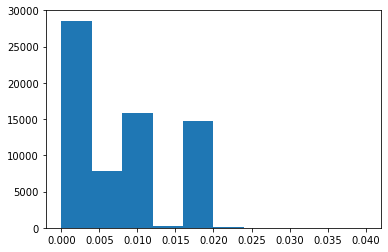

In [7]:
# plt.hist(data['timeStampDataPointStart_converted'], bins= 1000)
# plt.hist(goodData['time'].diff(), bins=10)

file = '1004_Session_5_ET_1_data_correTS_mad_wobig.csv'
data = pd.read_csv(os.path.join(data_savepath_intermediateP, file))  

sampleRate = data['timeStampDataPointStart_converted'].diff()
# plt.hist(data['timeStampDataPointStart_converted'].diff(), bins=10)

print(1/(np.min(sampleRate)))
print(1/(np.mean(sampleRate)))
print(1/(np.max(sampleRate)))

#sampleRate2 = goodData['time'].diff()
# plt.hist(data['timeStampDataPointStart_converted'].diff(), bins=10)
# print(1/np.min(sampleRate2))
# print(1/np.mean(sampleRate2))
# print(1/np.max(sampleRate2))

plt.hist(sampleRate, bins=10, range=(0, 0.04))

# plt.hist(sampleRate2)

In [80]:
pd.set_option('display.max_columns', None)

# Assuming 'data' is your DataFrame
data_head = data.head()

# Display head horizontally
with pd.option_context('display.max_rows', None, 'display.width', 1000):
#     display(data_head)
    display(goodData.iloc[0:100])


,Unnamed: 0,time,valid,xcoord,ycoord,zcoord,xcoord_orig,ycoord_orig,zcoord_orig,xlocal_dir,ylocal_dir,zlocal_dir,xhead,yhead,zhead,xhead_orig,yhead_orig,zhead_orig,xhpoo,yhpoo,zhpoo,hon,hon_all,xhop,yhop,zhop,blinks,combined_vel,HT_combined_vel,thresh,HT_thresh,isFix,HT_isFix,corrected_vel,events,length,distance,avg_dist,names,long_events
0,0,0.000,1.0,0.988025,0.005818,-0.154171,552.43690,2.069883,588.659200,0.154922,0.024078,0.987625,0.999888,-0.010349,-0.010787,552.478394,2.067765,588.611572,567.986633,2.200938,586.219482,NaN,NaN,571.75,0.38,585.530029,0.0,NaN,NaN,200.000000,200.000000,NaN,NaN,NaN,1.0,0.033,20.308743,17.708976,Lod_1,0.674491
1,1,0.011,1.0,0.987888,0.008326,-0.154994,552.44725,2.069924,588.658885,0.154922,0.024078,0.987625,0.999888,-0.010349,-0.010787,552.478394,2.067765,588.611572,567.986633,2.204091,586.203522,Lod_1,Lod_1,571.75,0.38,585.530029,0.0,NaN,0.000000,200.000000,200.000000,NaN,0.000000,NaN,NaN,0.033,20.298637,17.708976,Lod_1,0.674491
2,2,0.022,1.0,0.987546,0.008730,-0.157107,581.80470,2.052251,581.335900,0.155548,0.022919,0.987549,0.999885,-0.009384,-0.011892,552.498718,2.067715,588.611328,580.374207,1.455318,578.554993,NaN,Lod_1,571.75,0.38,585.530029,0.0,1.000000e+03,503.101067,0.000000,0.000000,NaN,NaN,1.000000e+03,NaN,0.033,9.959845,17.708976,Lod_1,0.674491
3,3,0.033,1.0,0.987290,0.011059,-0.158625,552.47797,2.069966,588.658100,0.155396,0.023254,0.987564,0.999876,-0.008616,-0.013196,552.519287,2.067704,588.611084,567.986633,2.243773,586.166809,NaN,Lod_1,571.75,0.38,585.530029,0.0,1.000000e+03,467.151021,0.000000,0.000000,NaN,NaN,1.000000e+03,-1.0,0.033,20.268678,17.708976,Lod_1,0.674491
4,4,0.044,1.0,0.987088,0.012213,-0.159858,552.49854,2.069966,588.656740,0.155167,0.023026,0.987610,0.999862,-0.008150,-0.014500,552.539612,2.067496,588.610840,567.986633,2.261752,586.166809,NaN,Lod_1,571.75,0.38,585.530029,0.0,5.968673e+00,345.755308,11.659949,323.512051,5.968673e+00,NaN,5.968673e+00,2.0,0.178,15.693875,15.540705,Lod_1,0.083364
5,5,0.056,1.0,0.987107,0.013870,-0.159628,552.51900,2.069954,588.656560,0.153625,0.023300,0.987839,0.999844,-0.007720,-0.015919,552.559265,2.067180,588.610535,567.986633,2.280148,586.166809,NaN,Lod_1,571.75,0.38,585.530029,0.0,5.605387e+00,289.052355,11.659949,323.512051,5.605387e+00,289.052355,5.605387e+00,NaN,0.178,15.673655,15.540705,Lod_1,0.083364
6,6,0.067,1.0,0.987402,0.013443,-0.157868,552.53840,2.069833,588.654050,0.150406,0.021988,0.988373,0.999822,-0.007597,-0.017292,552.580505,2.066928,588.610229,567.986633,2.287295,586.157043,NaN,Lod_1,571.75,0.38,585.530029,0.0,3.989827e+00,195.735691,11.659949,323.512051,3.989827e+00,195.735691,3.989827e+00,NaN,0.178,15.654108,15.540705,Lod_1,0.083364
7,7,0.077,1.0,0.987369,0.014050,-0.158076,552.55963,2.069672,588.653700,0.149292,0.021561,0.988556,0.999800,-0.007418,-0.018590,552.600830,2.066641,588.609863,567.986633,2.289191,586.163513,NaN,Lod_1,571.75,0.38,585.530029,0.0,2.444058e+00,196.565631,11.659949,323.512051,2.444058e+00,196.565631,2.444058e+00,NaN,0.178,15.633104,15.540705,Lod_1,0.083364
8,8,0.088,1.0,0.987043,0.015345,-0.159972,552.58010,2.069415,588.653700,0.149902,0.021744,0.988449,0.999774,-0.007121,-0.020017,552.620789,2.066400,588.609497,567.986633,2.308929,586.163513,NaN,Lod_1,571.75,0.38,585.530029,0.0,6.586203e+00,197.471854,11.659949,323.512051,6.586203e+00,197.471854,6.586203e+00,NaN,0.178,15.612908,15.540705,Lod_1,0.083364
9,9,0.100,1.0,0.987079,0.016282,-0.159751,552.60010,2.069153,588.654050,0.148438,0.021805,0.988678,0.999744,-0.006907,-0.021539,552.640686,2.066240,588.609131,567.986633,2.322952,586.162354,NaN,Lod_1,571.75,0.38,585.530029,0.0,4.307523e+00,150.601016,11.659949,323.512051,4.307523e+00,150.601016,4.307523e+00,NaN,0.178,15.593234,15.540705,Lod_1,0.083364


median of both data types
3.2642217806933145
10.67012299410869
mean of both data types
45.51703450198045
45.063388349829836


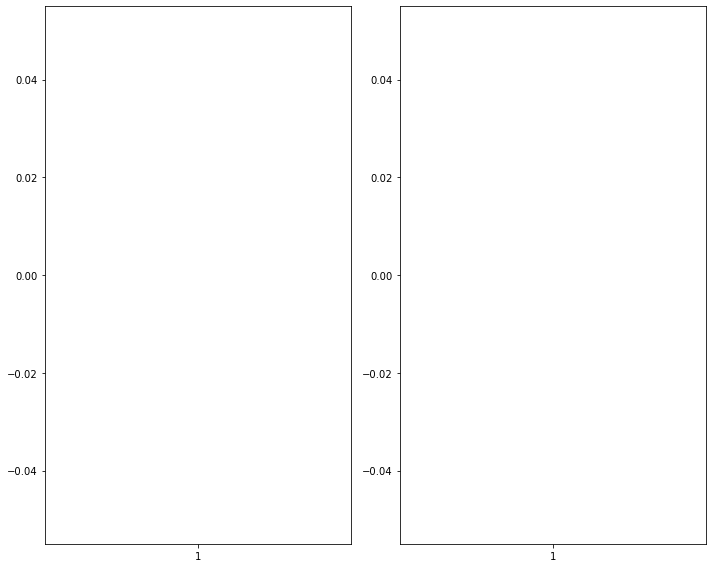

Lenght data 66789
Lenght good data 161903
number of zeros 1513
number of zeros good data 315
number of nans 337
number of nans good data 2212


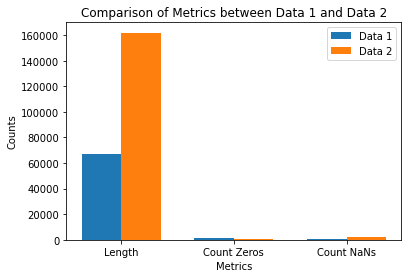

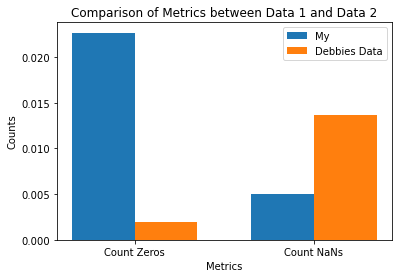

In [97]:
# test plot


# # Load your data frames (replace 'file1.csv' and 'file2.csv' with your file paths)
# file= "1004_Session_1_ET_1_data_correTS_mad_wobig.csv"
# data = pd.read_csv(os.path.join(data_savepath_intermediateP, file))

# file= "1004_Session_1_ET_1_data_processed_gazes.csv"
# data = pd.read_csv(os.path.join(data_savepath_processed_gazes, file))  

goodData = pd.read_csv('E:/WestbrookProject/DebbiesData//correTS_mad_wobig_70656182-09b3-4c19-9ae2-0a2ab2e19fed.csv')
file2 = "1004_Session_1_ET_1_interval_mad_wobig.csv"
int_data = pd.read_csv(os.path.join(data_savepath_intervals, file2))

# Specify the variable you want to compare
variable_name = 'combined_vel'

print("median of both data types")
print(np.nanmedian(data[variable_name]))
print(np.nanmedian(goodData[variable_name]))

print("mean of both data types")
print(np.nanmean(data[variable_name]))
print(np.nanmean(goodData[variable_name]))


# # Create subplots
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 8))

axes[0].boxplot(data[variable_name])
# axes[0].set_title(f'Boxplot of {variable_name} - my data')
# axes[0].legend()

axes[1].boxplot(goodData[variable_name])
# axes[1].set_title(f'Boxplot of {variable_name} - Debbies data')
# axes[1].legend()


# # Add labels and title
# for ax in axes:
#     ax.set_xlabel('Combined Velocity')
#     ax.set_ylabel('Values')

# Adjust layout
plt.tight_layout()

# Show the plots
plt.show()

# # Create subplots
# fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(10, 8))

# # Plot the distribution of the variable in the first subplot
# axes[0].hist(data[variable_name], color='blue', alpha=0.7, label='My Data')
# axes[0].set_title(f'Distribution of {variable_name} - my data')
# axes[0].legend()
# axes[0].set_xlim(0, 10)


# # Plot the distribution of the variable in the second subplot
# axes[1].hist(goodData[variable_name], color='orange', alpha=0.7, label='Good Data')
# axes[1].set_title(f'Distribution of {variable_name} - good data')
# axes[1].legend()
# axes[1].set_xlim(0, 10)

# # Adjust layout
# plt.tight_layout()

# # Show the plots
# plt.show()



print("Lenght data", len(data))
print("Lenght good data", len(goodData))

count_zeros = (data[variable_name] == 0).sum()
count_zeros2 = (goodData[variable_name] == 0).sum()


print("number of zeros", count_zeros)
print("number of zeros good data", count_zeros2)


count_nans = data[variable_name].isna().sum()
count_nans2 = goodData[variable_name].isna().sum()

print("number of nans", count_nans)
print("number of nans good data", count_nans2)


# Plotting
labels = ['Length', 'Count Zeros', 'Count NaNs']
data1_values = [len(data), count_zeros, count_nans]
data2_values = [len(goodData), count_zeros2, count_nans2]

bar_width = 0.35
index = np.arange(len(labels))

fig, ax = plt.subplots()

bar1 = ax.bar(index, data1_values, bar_width, label='Data 1')
bar2 = ax.bar(index + bar_width, data2_values, bar_width, label='Data 2')

ax.set_xlabel('Metrics')
ax.set_ylabel('Counts')
ax.set_title('Comparison of Metrics between Data 1 and Data 2')
ax.set_xticks(index + bar_width / 2)
ax.set_xticklabels(labels)
ax.legend()

plt.show()


# Plotting
labels = ['Count Zeros', 'Count NaNs']
data1_values = [count_zeros/len(data), count_nans/len(data)]
data2_values = [count_zeros2/len(goodData), count_nans2/len(goodData)]

bar_width = 0.35
index = np.arange(len(labels))

fig, ax = plt.subplots()

bar1 = ax.bar(index, data1_values, bar_width, label='My')
bar2 = ax.bar(index + bar_width, data2_values, bar_width, label='Debbies Data')

ax.set_xlabel('Metrics')
ax.set_ylabel('Counts')
ax.set_title('Comparison of Metrics between Data 1 and Data 2')
ax.set_xticks(index + bar_width / 2)
ax.set_xticklabels(labels)
ax.legend()

plt.show()


In [98]:

# Assuming you have a DataFrame df with columns 'time_stamp', 'isFix' indicating fixations (1) and saccades (0)
file = '1004_Session_1_ET_1_data_correTS_mad_wobig.csv'
data = pd.read_csv(os.path.join(data_savepath_intermediateP, file))  

import pandas as pd
import matplotlib.pyplot as plt

# Assuming you have a DataFrame df with columns 'time_stamp', 'isFix' indicating fixations (True) and saccades (False)

# Step 1: Preprocess the data to calculate fixation and saccade lengths
fix_lengths = []  # List to store fixation lengths
saccade_lengths = []  # List to store saccade lengths

fix_start_time = None  # Variable to store start time of fixation
saccade_start_time = None  # Variable to store start time of saccade

for index, row in data.iterrows():
    if row['isFix']:  # If fixation
        if fix_start_time is None:
            fix_start_time = row['timeStampDataPointStart_converted']
        fix_end_time = row['timeStampDataPointStart_converted']
    else:  # If saccade
        if fix_start_time is not None:  # If a fixation was started
            fix_lengths.append(fix_end_time - fix_start_time)
            fix_start_time = None  # Reset fix_start_time
    if not row['isFix']:  # If saccade
        if saccade_start_time is None:
            saccade_start_time = row['timeStampDataPointStart_converted']
        saccade_end_time = row['timeStampDataPointStart_converted']
    else:  # If fixation
        if saccade_start_time is not None:  # If a saccade was started
            saccade_lengths.append(saccade_end_time - saccade_start_time)
            saccade_start_time = None  # Reset saccade_start_time

# # Convert lengths to milliseconds for easier plotting (assuming timestamps are in milliseconds)
# fix_lengths_ms = [length.total_seconds() * 1000 for length in fix_lengths]
# saccade_lengths_ms = [length.total_seconds() * 1000 for length in saccade_lengths]

# Step 2: Create a density plot and histogram of fixation and saccade lengths
# fig, axs = plt.subplots(2)

# axs[0].hist(fix_lengths,  bins=1000,density=True, color='blue', alpha=0.7, label='Fixation Lengths')
# axs[0].set_title('Density Plot of Fixation Lengths')
# axs[0].set_xlabel('Fixation Length (ms)')
# axs[0].set_ylabel('Density')

# axs[1].hist(saccade_lengths, bins=1000, density=True, color='red', alpha=0.7, label='Saccade Lengths')
# axs[1].set_title('Density Plot of Saccade Lengths')
# axs[1].set_xlabel('Saccade Length (ms)')
# axs[1].set_ylabel('Density')

# plt.tight_layout()
# plt.show()

print(np.mean(fix_lengths))
print(np.mean(saccade_lengths))

print(np.median(fix_lengths))
print(np.median(saccade_lengths))

print(len(fix_lengths))
print(len(saccade_lengths))

1.14337779343824
0.0013220078286490758
0.666620135307312
0.0
514
514


# Length: Correct for long Events (outliers)

In [41]:
define_intervals

1

In [22]:
# perform median absolute deviation to find outliers in the event durations:
# https://hausetutorials.netlify.app/posts/2019-10-07-outlier-detection-with-median-absolute-deviation/

# Ashima:
# Finally, we rejected all fixations with a duration greater than 3.5 times the median absolute deviation of the
# population fixation duration...


plotting = False
g_len = []
s_len = []

######################################### start file loop

print('start round 1')
# useful overviews
noFilePartList = [len(PartList)]
missingFiles = pd.DataFrame(columns=['Participant', 'Session'])



# loop code over all participants in participant list
parts_pbar = tqdm(
    iterable=PartList,
    total=len(PartList),
    desc="participants",
    dynamic_ncols=True,
    bar_format=B_FORMAT,
)

for indexPart, currentPart in enumerate(parts_pbar):
#     currentPart = PartList[indexPart]
    print(f'Participant {indexPart} - participant ID {currentPart}')
    
    sessions = list(range(1,6))
#     sessions = list(range(2,3))
    
    session_pbar = tqdm(
        iterable=sessions,
        total=len(sessions),
        desc="sessions________",
        dynamic_ncols=True,
        bar_format=B_FORMAT,
    )
    
    
    # loop over recording sessions (should be 5 for each participant)
#     for indexSess in range(1, 6):
#     for indexSess in range(1, 2):
    for indexSess in session_pbar:

        # get all eye tracking sessions and loop over them (amount of ET files can vary)
        fileNames = [f for f in os.listdir(data_savepath_intermediateP) if f.startswith(f'{currentPart}_Session_{indexSess}') and f.endswith('_data_correTS_mad_wobig.csv')]
#         print(dirSess)
#         print(f'Session {indexSess}')
        
        if len(fileNames)< 3:
            hMF = pd.DataFrame({'Participant': [currentPart], 'Session': [indexSess], 'onlyExistingFilesInSession': [fileNames]})
            missingFiles = pd.concat([missingFiles, hMF], ignore_index=True)
            

        # files progress bar
        file_pbar = tqdm(
            iterable=fileNames,
            total=len(fileNames),
            desc="📂 ET files____________",
            dynamic_ncols=True,
            bar_format=B_FORMAT,
        )

            # loop necessary for displaying properly the progressbar with multiprocessing
            # source: https://stackoverflow.com/a/40133278

#             info_list = []

        for file in file_pbar:

            print('process file ', file)

            # read in data
            data = pd.read_csv(os.path.join(data_savepath_intermediateP, file))

    ######################## start main code here:

            data = data[data['cleanData'] == True]

            data = data[~data["isBlink"].isnull()]

            # separate between gaze and saccade
            gaze = data[data["events"] == 2.0]
            sacc = data[
                data["events"] == 1.0
            ]  # as we do not always have 1.0 in the data, we take the end

            g_len = g_len + gaze["length"].tolist()
            s_len = s_len + sacc["length"].tolist()
            
                    
if len(missingFiles)>0:
    
    print("missing files detected in part 1")
    print(missingFiles)
    
else:
    print("All files were found")
                
#########################

# median of the absolute deviation (* 1.4826 when assuming normal distribution):
gaze_mad = np.nanmedian(abs(g_len - np.nanmedian(g_len))) * 1.4826
sacc_mad = np.nanmedian(abs(s_len - np.nanmedian(s_len))) * 1.4826

# calculate the median to reject data
g_len_med = np.nanmedian(g_len)
s_len_med = np.nanmedian(s_len)


################# start second loop here

print('start round 2')
# useful overviews
noFilePartList = [len(PartList)]
missingFiles = pd.DataFrame(columns=['Participant', 'Session'])



# loop code over all participants in participant list
parts_pbar = tqdm(
    iterable=PartList,
    total=len(PartList),
    desc="participants",
    dynamic_ncols=True,
    bar_format=B_FORMAT,
)

for indexPart, currentPart in enumerate(parts_pbar):
#     currentPart = PartList[indexPart]
    print(f'Participant {indexPart} - participant ID {currentPart}')
    
    sessions = list(range(1,6))
#     sessions = list(range(2,3))
    
    session_pbar = tqdm(
        iterable=sessions,
        total=len(sessions),
        desc="sessions________",
        dynamic_ncols=True,
        bar_format=B_FORMAT,
    )
    
    # loop over recording sessions (should be 5 for each participant)
#     for indexSess in range(1, 6):
#     for indexSess in range(1, 2):
    for indexSess in session_pbar:

        # get all eye tracking sessions and loop over them (amount of ET files can vary)
        fileNames = [f for f in os.listdir(data_savepath_intermediateP) if f.startswith(f'{currentPart}_Session_{indexSess}') and f.endswith('_data_correTS_mad_wobig.csv')]
#         print(dirSess)
#         print(f'Session {indexSess}')
        
        if len(fileNames)< 3:
            hMF = pd.DataFrame({'Participant': [currentPart], 'Session': [indexSess], 'onlyExistingFilesInSession': [fileNames]})
            missingFiles = pd.concat([missingFiles, hMF], ignore_index=True)
            
        
        # runs if files exist

        # files progress bar
        file_pbar = tqdm(
            iterable=fileNames,
            total=len(fileNames),
            desc="📂 ET files____________",
            dynamic_ncols=True,
            bar_format=B_FORMAT,
        )

            # loop necessary for displaying properly the progressbar with multiprocessing
            # source: https://stackoverflow.com/a/40133278

#             info_list = []

        for file in file_pbar:

            print('process file ', file)

            # read in data
            data = pd.read_csv(os.path.join(data_savepath_intermediateP, file))

    ################ main code starts here#######

            invalid = data[data['cleanData'] == False]
            data = data[data['cleanData'] == True]

            # separate between gaze and saccade
            gaze = data[~data["isFix"].isnull()]
            sacc = data[data["isFix"].isnull()]

            # Deviations:
            # then to calculate the deviations using the entire df for easy lookup later
            gaze_mad_z = abs(gaze["length"].tolist() - g_len_med) / gaze_mad
            sacc_mad_z = abs(sacc["length"].tolist() - s_len_med) / sacc_mad

            # get the outliers:
            gaze_mad_z[gaze_mad_z > 3.5] = np.nan
            sacc_mad_z[sacc_mad_z > 3.5] = np.nan

            # save the data:
            data = pd.concat([gaze, sacc, invalid])
            data["long_events"] = gaze_mad_z.tolist() + sacc_mad_z.tolist() + [np.nan] * len(invalid)
            data = data.sort_index()

            # save df:
            # 1 == MAD_woBig

            if define_intervals == 1:
                # save interval
                saveName = file.replace("data_correTS_mad_wobig.csv", "data_processed_gazes.csv")
                data.to_csv(os.path.join(data_savepath_processed_gazes, saveName), index = False)
            # 2 == 10_sec
            else:
                print("why are you using the 10 sec interval, it is not fully adapted in this script")
                    
if len(missingFiles)>0:
    
    print("missing files detected in part 2")
    print(missingFiles)
    
else:
    print("All files were found")
        

start round 1


📄 0 of 1 participants processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

Participant 0 - participant ID 1004


📄 0 of 5 sessions________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1004_Session_1_ET_1_data_correTS_mad_wobig.csv
process file  1004_Session_1_ET_2_data_correTS_mad_wobig.csv
process file  1004_Session_1_ET_3_data_correTS_mad_wobig.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1004_Session_2_ET_1_data_correTS_mad_wobig.csv
process file  1004_Session_2_ET_2_data_correTS_mad_wobig.csv
process file  1004_Session_2_ET_3_data_correTS_mad_wobig.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1004_Session_3_ET_1_data_correTS_mad_wobig.csv
process file  1004_Session_3_ET_2_data_correTS_mad_wobig.csv
process file  1004_Session_3_ET_3_data_correTS_mad_wobig.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1004_Session_4_ET_1_data_correTS_mad_wobig.csv
process file  1004_Session_4_ET_2_data_correTS_mad_wobig.csv
process file  1004_Session_4_ET_3_data_correTS_mad_wobig.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1004_Session_5_ET_1_data_correTS_mad_wobig.csv
process file  1004_Session_5_ET_2_data_correTS_mad_wobig.csv
process file  1004_Session_5_ET_3_data_correTS_mad_wobig.csv
All files were found
start round 2


📄 0 of 1 participants processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

Participant 0 - participant ID 1004


📄 0 of 5 sessions________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1004_Session_1_ET_1_data_correTS_mad_wobig.csv
process file  1004_Session_1_ET_2_data_correTS_mad_wobig.csv
process file  1004_Session_1_ET_3_data_correTS_mad_wobig.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1004_Session_2_ET_1_data_correTS_mad_wobig.csv
process file  1004_Session_2_ET_2_data_correTS_mad_wobig.csv
process file  1004_Session_2_ET_3_data_correTS_mad_wobig.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1004_Session_3_ET_1_data_correTS_mad_wobig.csv
process file  1004_Session_3_ET_2_data_correTS_mad_wobig.csv
process file  1004_Session_3_ET_3_data_correTS_mad_wobig.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1004_Session_4_ET_1_data_correTS_mad_wobig.csv
process file  1004_Session_4_ET_2_data_correTS_mad_wobig.csv
process file  1004_Session_4_ET_3_data_correTS_mad_wobig.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1004_Session_5_ET_1_data_correTS_mad_wobig.csv
process file  1004_Session_5_ET_2_data_correTS_mad_wobig.csv
process file  1004_Session_5_ET_3_data_correTS_mad_wobig.csv
All files were found


In [86]:
## plotting some gazes
# ids = recordings.index.tolist()
# idd = [1]
# for uid in idd:
#     file = "1004_Session_1_ET_1_data_correTS_mad_wobig.csv"
#     data = pd.read_csv(os.path.join(data_savepath_intermediateP, "1004_Session_1_ET_1_data_correTS_mad_wobig.csv"))
        
#     gaze = data[data["events"] == 2.0]
#     gaze = gaze[~gaze["long_events"].isnull()]

#     gaze = gaze[~gaze["names"].isnull()]
#     display(gaze)
#     display(np.mean(gaze['length']))